ENV: spatial_ced_1

# Reconstruct zonation patterns

## Import

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(0)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from scipy.sparse import csc_matrix
from scipy.io import savemat
import dill
import json
import gseapy
import matplotlib as mpl
import math
import scipy
import plotly.express as px
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
from scipy.stats import ttest_ind

from skimage.morphology import skeletonize
from skimage.graph import MCP
from skimage.measure import label
from scipy.ndimage import convolve
import tifffile as tiff


# from rasterio import features
from skimage.transform import resize
from skimage.measure import label, regionprops
# import rasterio
from shapely.geometry import LineString
from scipy.ndimage import gaussian_filter1d

from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

import gseapy as gp
import sys
shedding_paper_utils = "/mnt/x/Common/Lab_Papers/shedding_potential/utils"
sys.path.append(shedding_paper_utils)
import plot_gsea
import importlib
# import py_funcs
import session_info2


mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator
plt.rcParams.update({
    "font.size": 14,    
    "axes.titlesize": 16,    
    "axes.labelsize": 14,  
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,  
    "legend.fontsize": 14
})
LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = '/mnt/x/common/joint_projects/spatial_celiac/utils/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

In [2]:
fields_to_dist = ['lowest_lumen','crypt_base']
crypt_field = 'MM_LP_crypt'
villus_field = 'villus'
fields_to_identify = [crypt_field,'brunner',villus_field]
macrozone_field = 'macrozone'
pixel_classifier_field = 'pixel_class'

In [3]:
def calc_noise_mean_curve(mean_exp_df, plot_top_N_genes=None,PN=1e-6):
    noise_mean_df = pd.DataFrame()
    noise_mean_df['mean'] = mean_exp_df.mean(axis=1).astype(float)
    noise_mean_df['std'] = mean_exp_df.std(axis=1).astype(float)
    noise_mean_df['cv'] = (PN+noise_mean_df['std']) / (PN+noise_mean_df['mean'])
    noise_mean_df['log_mean'] = np.log10(noise_mean_df['mean']+PN)
    noise_mean_df['log_std'] = np.log10(noise_mean_df['std']+PN)
    noise_mean_df['log_cv'] = np.log10(noise_mean_df['cv']+PN)
    from sklearn.linear_model import LinearRegression
    X = noise_mean_df[['log_mean']]
    y = noise_mean_df['log_cv']
    model = LinearRegression()
    model.fit(X, y)
    noise_mean_df['predicted_log_cv'] = model.predict(X)
    noise_mean_df['residuals'] = noise_mean_df['log_cv'] - noise_mean_df['predicted_log_cv']
    noise_mean_df['zscore'] = zscore(noise_mean_df['residuals'])
    
    if plot_top_N_genes is not None:
        # plot the noise-mean curve
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=noise_mean_df, x='log_mean', y='log_cv', hue='residuals', alpha=0.5)
        plt.plot(noise_mean_df['log_mean'], model.predict(X), color='red', label='Linear Fit')
        plt.xlabel('log10(Mean Expression)')
        plt.ylabel('log10(CV)')
        plt.title('Noise-Mean Curve')
        plt.legend()
        # add text to the most extreme 10 positive residuals
        texts = []
        for i, row in noise_mean_df.nlargest(plot_top_N_genes, 'residuals').iterrows():
            texts.append(plt.text(row['log_mean'], row['log_cv'], row.name))
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=1))
        plt.show()

    noise_mean_df.sort_values(by='residuals', ascending=False, inplace=True)
    return noise_mean_df


def sort_by_com(show_df, max_normalize=False):
    com_df = pd.DataFrame(index=show_df.index, columns=['center_of_mass'])
    for gene in show_df.index:
        com = np.sum(show_df.loc[gene].values * np.arange(len(show_df.columns))) / np.sum(show_df.loc[gene].values)
        com_df.loc[gene, 'center_of_mass'] = com
    com_df = com_df.sort_values(by='center_of_mass')

    # sort show_df by com_df
    show_df = show_df.loc[com_df.index]
    if max_normalize:
        show_df = show_df.div(show_df.max(axis=1), axis=0)
    return show_df,com_df

def invert_df_columns(df):
    return df[df.columns[::-1]]

def add_prefix_to_columns(df, prefix):
    df.columns = [prefix + str(col) for col in df.columns]
    return df

EXP_THRESH = 1e-4

dist_map_dict = {
        "crypt_7":-750,
        "crypt_6":-650,
        "crypt_5":-550,
        "crypt_4":-450,
        "crypt_3":-350,
        "crypt_2":-250,
        "crypt_1":-150,
        "crypt_0":-50,
        "villus_0":50,
        "villus_1":150,
        "villus_2":250,
        "villus_3":350,
        "villus_4":450,
        "villus_5":550,
        "villus_6":650,
        "villus_7":750,
    }

## Load and preprocess data

In [4]:
fast_load = True
if fast_load:
    fast_load_prefix = "/mnt/d/celiac_files/"
else:   
    fast_load_prefix = ""

In [5]:
# import FLEX and extract tip and crypt telocytes, then identify thier markers, and show thier sum in celiac and control
sc_ad = sc.read_h5ad(fast_load_prefix+"10x_flex_all_samples_processed_bg.h5ad")
sc_ad

AnnData object with n_obs × n_vars = 53270 × 18129
    obs: 'sample_name', 'batch', 'clinical_group', 'processing_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'log10_total_counts', 'leiden', 'cell_type_lvl1', 'cell_type_lvl2', 'epi_umap1', 'epi_umap2', 'entero_umap1', 'entero_umap2', 'stroma_umap1', 'stroma_umap2', 'epi_leiden', 'stroma_leiden', 'imm_leiden', 'stroma_umap_1', 'stroma_umap_2', 'immune_umap_1', 'immune_umap_2'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells_by_counts-

In [6]:
joint_ad_path = fast_load_prefix+'joint_ad.dill'#'all_ad_w_annotations_UMI100_leiden1.5.dill'#'joint_ad.dill'

with open(joint_ad_path, 'rb') as f:
    all_ad = dill.load(f)

In [7]:
# remove pixel_class == "NA"
all_ad = all_ad[all_ad.obs["pixel_class"].isin(['epithelium','non_epithelium']), :]

# remove pixels that are not in villus or crypt
all_ad = all_ad[all_ad.obs['MM_LP_crypt']+all_ad.obs['villus'],:]


# filter out brunner glands
all_ad = all_ad[~all_ad.obs['brunner']]

# filter out immune
all_ad = all_ad[~all_ad.obs['immune']]

In [8]:
# create dataframe with sample names and median sum of umis
sample_medians = all_ad.obs.groupby('sample_name')['sum_of_umis'].median().reset_index()
sample_medians.columns = ['sample_name', 'median_sum_of_umis']
UMI_THRESH = 20
sample_medians['above_thresh'] = sample_medians['median_sum_of_umis'] > UMI_THRESH
selected_samples = sample_medians[sample_medians['above_thresh']]['sample_name'].tolist()
print(f"Selected samples: {selected_samples}")
sample_medians

Selected samples: ['ST_004', 'ST_033', 'ST_038', 'ST_046', 'ST_052', 'ST_054', 'ST_060', 'ST_072', 'ST_073', 'ST_076', 'ST_080B1', 'ST_080B2', 'ST_109B1', 'ST_109B2']


,sample_name,median_sum_of_umis,above_thresh
0,ST_004,31.0,True
1,ST_033,139.0,True
2,ST_038,76.0,True
3,ST_046,265.0,True
4,ST_052,160.0,True
5,ST_054,48.0,True
6,ST_060,197.0,True
7,ST_072,88.0,True
8,ST_073,504.0,True
9,ST_076,32.0,True


In [9]:
# keep only selected samples
print(all_ad.shape)
all_ad = all_ad[all_ad.obs['sample_name'].isin(selected_samples), :]
print(all_ad.shape)
print(all_ad.obs['sample_name'].unique())

(332411, 18085)
(315825, 18085)
['ST_033' 'ST_038' 'ST_046' 'ST_052' 'ST_073' 'ST_054' 'ST_004' 'ST_072'
 'ST_060' 'ST_076' 'ST_080B1' 'ST_109B1' 'ST_080B2' 'ST_109B2']


In [10]:
samples_to_drop = ["ST_060","ST_073","ST_080B2","ST_109B2",]# "ST_076","ST_105"] # "ST_080B1","ST_109B1",
# samples_to_drop = ["ST_060","ST_073","ST_080B2","ST_109B2", "ST_076","ST_105"] # "ST_080B1","ST_109B1",
# exclusion criteria: 
# 60/73 - early marsh
print(all_ad.shape)
all_ad = all_ad[~all_ad.obs.sample_name.isin(samples_to_drop)]
print(all_ad.shape)
print(all_ad.obs['sample_name'].unique())

(315825, 18085)
(227549, 18085)
['ST_033' 'ST_038' 'ST_046' 'ST_052' 'ST_054' 'ST_004' 'ST_072' 'ST_076'
 'ST_080B1' 'ST_109B1']


In [11]:
# add total sum of umis per sample
sample_sum_umis = all_ad.obs.groupby('sample_name')['sum_of_umis'].sum()
samples_to_drop = sample_sum_umis[sample_sum_umis < 0].index
print(all_ad.shape)
all_ad = all_ad[~all_ad.obs.sample_name.isin(samples_to_drop)]
print(all_ad.shape)

(227549, 18085)
(227549, 18085)


In [12]:
print(all_ad.obs['sample_name'].unique())

['ST_033' 'ST_038' 'ST_046' 'ST_052' 'ST_054' 'ST_004' 'ST_072' 'ST_076'
 'ST_080B1' 'ST_109B1']


In [13]:
# drop samples with "B1" at thier name
print(all_ad.shape)
# all_ad = all_ad[~all_ad.obs.sample_name.str.contains("B1"), :]
# rename samples to remove "B1" suffix
all_ad.obs['sample_name'] = all_ad.obs['sample_name'].str.replace("B1","")
print(all_ad.shape)

(227549, 18085)


(227549, 18085)


## Calculate mean expression accorss compartments and anatomical regions

In [14]:
compartment_fields = ['epithelium','non_epithelium', 'all'] # make sure to use lower case
crypt_field = ['crypt','villus']
BIN_SPACE = 100
NUM_ZONES = 8

pts_to_drop = []

brunner_pxls = all_ad.obs.brunner[all_ad.obs.brunner].index.tolist()
immune_pxls = all_ad.obs.immune[all_ad.obs.immune].index.tolist()

samples = all_ad.obs.sample_name.unique()
all_ad.obs['dist_bin'] = np.nan
all_ad.obs['dist_bin_ttl'] = np.nan

# iterate along every sample
sample_dict = dict()
joint_sample_dict = dict()
pxls_df = pd.DataFrame(columns=['sample_name','crypt-villus','compartment','bin','num_pixels'])
for my_sample in tqdm(all_ad.obs.sample_name.unique()):
    sample_dict[my_sample] = dict()
    joint_sample_dict[my_sample] = dict()

    # print(f"Processing sample: {my_sample}")

    # iterate along crypt/villus
    for my_crypt_field in crypt_field:
        sample_dict[my_sample][my_crypt_field] = dict()

        if my_crypt_field == 'crypt':
            pxls = all_ad.obs.MM_LP_crypt[all_ad.obs.MM_LP_crypt].index.tolist()
        elif my_crypt_field == 'villus':
            pxls = all_ad.obs.villus[all_ad.obs.villus].index.tolist()

        # iterate along epithelium/non-epithelium
        for pixel_class in compartment_fields:
            # print(f"Processing pixel class: {pixel_class} of {my_crypt_field} in {my_sample}")
            sample_dict[my_sample][my_crypt_field][pixel_class] = dict()

            # select pixels of the sample-crypt_field-pixel_class
            sample_pxls = all_ad.obs[all_ad.obs.sample_name == my_sample].index.tolist()
            
            if pixel_class != 'all':
                pixel_class_pxls = all_ad.obs.pixel_class[all_ad.obs.pixel_class == pixel_class].index.tolist()
                sample_pxls = np.intersect1d(sample_pxls, pixel_class_pxls)

            sample_pxls = np.intersect1d(sample_pxls, pxls)
            sample_pxls = np.setdiff1d(sample_pxls, brunner_pxls) # remove brunner
            sample_pxls = np.setdiff1d(sample_pxls, immune_pxls) # remove immune

            if len(sample_pxls) == 0:
                pts_to_drop.append(my_sample)
                continue

            bins = np.arange(0, NUM_ZONES*BIN_SPACE+1, BIN_SPACE)
            # bins[-1] = np.max(all_ad[sample_pxls].obs.lowest_lumen)
            # print(bins)

            sample_mn = pd.DataFrame(np.zeros([len(all_ad.var_names), NUM_ZONES]), all_ad.var_names, range(NUM_ZONES))
            sample_mn.index.name = "gene_name"
            sample_se = sample_mn.copy()

            # iterate along the bins
            PIXELS_THRESH = 10
            for ii in range(NUM_ZONES):
                bin_mask = (all_ad[sample_pxls].obs.lowest_lumen >= bins[ii]) & (all_ad[sample_pxls].obs.lowest_lumen < bins[ii+1])
                bin_pxls = bin_mask[bin_mask].index.tolist()
                all_ad.obs.loc[bin_pxls,'dist_bin'] = dist_map_dict[my_crypt_field+"_"+str(ii)]
                all_ad.obs.loc[bin_pxls,'dist_bin_ttl'] = my_crypt_field+"_"+str(ii)
                bin_pxls_count = len(bin_pxls)
                if (bin_pxls_count < PIXELS_THRESH) & (bin_pxls_count > 0):
                    print(f"{my_sample}: dropping {my_crypt_field} {pixel_class} bin {ii} - #pxls = {bin_pxls_count} ")
                    bin_pxls =[]

                bin_counts_sum = all_ad[bin_pxls].layers['counts'].sum(axis=0).A1
                bin_counts_mat_norm = bin_counts_sum / np.sum(bin_counts_sum)
                # bin_mn = all_ad[bin_pxls].layers['mat_norm'].todense().mean(axis=0).A1
                sample_mn.iloc[:, ii] = bin_counts_mat_norm
                # sample_se.iloc[:, ii] =np.std(all_ad[bin_pxls].layers['mat_norm'].todense())/np.sqrt(len(bin_pxls)) # we dont have SE for pseudobulk
                # add row for the dataframe
                if bin_pxls_count > 0:
                    pxls_df = pd.concat([pxls_df, pd.DataFrame({'sample_name': my_sample, 
                                                            'crypt-villus': my_crypt_field, 
                                                            'compartment': pixel_class, 
                                                            'bin': ii,
                                                            "num_pixels":bin_pxls_count}, index=[0])], ignore_index=True)

            # save the mean and standard error for each condition
            sample_dict[my_sample][my_crypt_field][pixel_class]['mn'] = sample_mn
            # sample_dict[my_sample][my_crypt_field][pixel_class]['se'] = sample_se

    # remove samples that have no pixels in the crypt/villus
    pts_to_drop = list(set(pts_to_drop))  # remove duplicates
    for my_sample in pts_to_drop:
        print(f"Removing sample {my_sample} due to no pixels in crypt/villus")
        del sample_dict[my_sample]
        del joint_sample_dict[my_sample]

    # ADD JOINT MEAN FOR CRYPT AND VILLUS
    if my_sample not in pts_to_drop:
        for pixel_class in compartment_fields:
            crypt_df = add_prefix_to_columns(invert_df_columns(sample_dict[my_sample]['crypt'][pixel_class]['mn'].copy()), 'crypt_')
            villus_df = add_prefix_to_columns(sample_dict[my_sample]['villus'][pixel_class]['mn'].copy(), 'villus_')
            # crypt_df_se = add_prefix_to_columns(invert_df_columns(sample_dict[my_sample]['crypt'][pixel_class]['se'].copy()), 'crypt_')
            # villus_df_se = add_prefix_to_columns(sample_dict[my_sample]['villus'][pixel_class]['se'].copy(), 'villus_')
            
            joint_df = pd.concat([crypt_df, villus_df], axis=1)
            # joint_df = joint_df.dropna(axis=1)
            # joint_df_se = pd.concat([crypt_df_se, villus_df_se], axis=1)
            # joint_df_se = joint_df_se.dropna(axis=1)

            joint_sample_dict[my_sample][pixel_class] = dict()
            joint_sample_dict[my_sample][pixel_class]['mn'] = joint_df.copy()
            # joint_sample_dict[my_sample][pixel_class]['se'] = joint_df_se.copy()
    else:
        pts_to_drop.remove(my_sample)  # remove from pts_to_drop to avoid further processing
        print("Dropping sample {}".format(my_sample))

  0%|          | 0/10 [00:00<?, ?it/s]

ST_033: dropping villus non_epithelium bin 4 - #pxls = 1 


 20%|██        | 2/10 [00:18<01:12,  9.06s/it]

ST_046: dropping villus non_epithelium bin 5 - #pxls = 4 


 40%|████      | 4/10 [00:29<00:40,  6.68s/it]

ST_054: dropping villus epithelium bin 1 - #pxls = 1 
ST_054: dropping villus non_epithelium bin 1 - #pxls = 2 


 50%|█████     | 5/10 [00:36<00:33,  6.75s/it]

ST_054: dropping villus all bin 1 - #pxls = 3 


 70%|███████   | 7/10 [00:48<00:18,  6.30s/it]

ST_076: dropping villus epithelium bin 3 - #pxls = 2 
ST_076: dropping villus all bin 3 - #pxls = 2 


 80%|████████  | 8/10 [00:52<00:11,  5.69s/it]

ST_080: dropping crypt epithelium bin 4 - #pxls = 5 


 90%|█████████ | 9/10 [00:57<00:05,  5.54s/it]

ST_109: dropping villus epithelium bin 1 - #pxls = 3 


100%|██████████| 10/10 [01:02<00:00,  6.20s/it]

ST_109: dropping villus all bin 1 - #pxls = 3 


In [15]:
# if False:

#     st33_ad = all_ad[all_ad.obs.sample_name == "ST_033"].copy()

#     ct_path = "/mnt/x/Common/Joint_projects/spatial_celiac/visiumhd_experiment1/5_outs/CT/"
#     ct_path_08 = ct_path+"/binned_outputs/square_008um/"
#     scalefactor_path = ct_path_08+"/spatial/scalefactors_json.json"
#     scalefactors_ct = pd.read_json(scalefactor_path, typ='series')

#     ct_image_path = f"../visiumhd_experiment1/4_files_for_processing/brightened_Celiac_slide2-6_merged_celiac_slide2-6_ch00.tif"
#     ct_image = tiff.imread(ct_image_path)

#     ct_image_cropped = ct_image[:12500, :10000]
#     fig, ax = plt.subplots(figsize=(5,5))
#     ax.imshow(ct_image_cropped, cmap='gray')
#     plt.show()

#     st33_ad

In [16]:
# create dir for fig if not exists
corr_fig_save_path = os.getcwd()+"/figures/supp_tip_base_correlation"
if not os.path.exists(corr_fig_save_path):
    os.makedirs(corr_fig_save_path)

In [17]:
# min_col_px, max_col_px = 4250,5500
# min_row_px, max_row_px = 8450, 10100
# st33_pxls = (st33_ad.obs['pxl_col_in_fullres'] > min_col_px) & (st33_ad.obs['pxl_col_in_fullres'] < max_col_px)
# st33_pxls = st33_pxls * ((st33_ad.obs['pxl_row_in_fullres'] > min_row_px) & (st33_ad.obs['pxl_row_in_fullres'] < max_row_px))
# st33_pxls_names = st33_ad.obs_names[st33_pxls]
# fig, ax = plt.subplots(figsize=(5,5), dpi=300)
# ax.imshow(ct_image_cropped)
# dot_size = 15
# sns.scatterplot(st33_ad[st33_pxls_names].obs,ax=ax,
#                 x='pxl_col_in_fullres', y='pxl_row_in_fullres',
#                  hue='dist_bin_ttl',marker='s',
#                 edgecolor=None,alpha=0.8,s=dot_size, palette='Set1')

# sns.scatterplot(st33_ad[st33_pxls*(st33_ad.obs['lowest_lumen'] == 0)].obs,ax=ax,
#                 x='pxl_col_in_fullres', y='pxl_row_in_fullres',marker='s',
#                 edgecolor=None,alpha=0.6,s=dot_size,c='black')

# plt.title("P033 (Control)")
# plt.xticks([])
# plt.yticks([])
# plt.xlabel("")
# plt.ylabel("")

# ax.set_xlim(min_col_px, max_col_px)
# ax.set_ylim(max_row_px, min_row_px)
# ax.invert_yaxis()
# # ax.legend_.remove()

# # Add legend outside the plot
# handles, labels = ax.get_legend_handles_labels()
# legend_dict = {"crypt_2":"Crypt -250µm", "crypt_1":"Crypt -150µm", "crypt_0":"Crypt -50µm", "villus_0":"Villus 50µm", "villus_1":"Villus 150µm", "villus_2":"Villus 250µm", "villus_3":"Villus 350µm", }
# labels = [legend_dict[label] if label in legend_dict else label for label in labels]
# ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Distance Bin")

# for collection in ax.collections:
#     collection.set_rasterized(True)

# scalebar_y = 8500
# start_bar_x = 4300
# scalebar_length_um = 100
# end_bar_x = start_bar_x + scalebar_length_um / scalefactors_ct['microns_per_pixel']# plt.text(start_bar_x, scalebar_y - 100, f"{scalebar_length_um} µm", color='black', fontsize=8, ha='left', va='top', fontweight='bold')
# plt.text((start_bar_x+end_bar_x)/2, scalebar_y + 80, f"{scalebar_length_um} µm", color='black', fontsize=12, ha='center', va='top')
# plt.plot([start_bar_x, end_bar_x], [scalebar_y, scalebar_y], color='black', linewidth=1, solid_capstyle='butt')

# fig.savefig(corr_fig_save_path+"/villi_dist_sample.pdf",dpi=300)

# plt.show()
# # rasterize

## Calculate mean zonation patterns and COM in different groups

In [18]:
PN = 1e-6
smoothing_sigma = 3

group_com_dict = dict()
pt_com_dict = dict()
group_masks = dict()
weights = np.arange(NUM_ZONES*2)+1  # Create weights corresponding to the zones

KEEP_ONLY_COLS_WITH_ALL_PTS = False

for my_group in tqdm(all_ad.obs['group'].unique()):
# for my_group in tqdm(['control']):
    print(f"Processing group: {my_group}")
    group_com_dict[my_group] = dict()
    my_pts = np.intersect1d(all_ad.obs[all_ad.obs['group'] == my_group].sample_name.unique(), list(joint_sample_dict.keys()))
    for my_compartment in compartment_fields:
        group_com_dict[my_group][my_compartment] = dict()

        # create 3d array where each slice is a patient, for each compartment and crypt/villus
        group_pts = np.zeros([len(my_pts), len(all_ad.var_names), NUM_ZONES*2])
        # group_pts_se = np.zeros([len(my_pts), len(all_ad.var_names), NUM_ZONES*2])

        # fill the 3d array with the mean and standard error for each condition
        # iterate along the patients
        for ii, pt in enumerate(my_pts):
            group_pts[ii, :, :] = joint_sample_dict[pt][my_compartment]['mn'].values
            # group_pts_se[ii, :, :] = joint_sample_dict[pt][my_compartment]['se'].values

            # also save the com for each patient
            if pt not in pt_com_dict:
                pt_com_dict[pt] = dict()
            pt_com_dict[pt][my_compartment] = dict()
            pt_com_dict[pt][my_compartment]['mn'] = joint_sample_dict[pt][my_compartment]['mn'].copy()
            # pt_com_dict[pt][my_compartment]['se'] = joint_sample_dict[pt][my_compartment]['se'].copy()
            pt_com = (joint_sample_dict[pt][my_compartment]['mn'] * weights).sum(axis=1) / joint_sample_dict[pt][my_compartment]['mn'].sum(axis=1)  # Calculate COM for each row
            pt_com = pt_com.sort_values(ascending=True)
            # pt_com_dict[pt][my_compartment]['com'] = pt_com.copy()
            # pt_com_dict[pt][my_compartment]['com_01'] = (pt_com - np.min(pt_com))/(np.max(pt_com) - np.min(pt_com))

        # print(np.sum(np.isnan(group_pts[:,1,:]),axis=0))
        max_na_frac = 0.5 #1=use all data/ 0=use only datapoints with all subjuects
        if KEEP_ONLY_COLS_WITH_ALL_PTS:
            max_na_frac=0
            
        # keep columns with elements in at least max_na_fract(0.5) of the patients
        group_masks[my_group] = np.sum(np.isnan(group_pts[:,1,:]),axis=0) <= group_pts.shape[0]*max_na_frac
        # print(group_masks[my_group])

        group_com_dict[my_group][my_compartment]['mean_zonation'] = pd.DataFrame(
            np.nanmean(group_pts, axis=0),index=all_ad.var_names, columns=joint_sample_dict[pt][my_compartment]['mn'].columns)
        # We can calculate SE using the std across patients divided by sqrt of number of patients
        group_com_dict[my_group][my_compartment]['se_zonation'] = pd.DataFrame(
            np.nanstd(group_pts, axis=0)/np.sqrt(len(my_pts)), index=all_ad.var_names, columns=joint_sample_dict[pt][my_compartment]['mn'].columns)

        # filter columns that do not have enough patients
        group_com_dict[my_group][my_compartment]['mean_zonation'] = group_com_dict[my_group][my_compartment]['mean_zonation'].loc[:,group_masks[my_group]]
        group_com_dict[my_group][my_compartment]['se_zonation'] = group_com_dict[my_group][my_compartment]['se_zonation'].loc[:,group_masks[my_group]]

        # Drop columns where the sum of 'mean_zonation' is zero
        keep_mask = group_com_dict[my_group][my_compartment]['mean_zonation'].sum(axis=1) != 0
        group_com_dict[my_group][my_compartment]['mean_zonation'] = group_com_dict[my_group][my_compartment]['mean_zonation'].loc[keep_mask]
        group_com_dict[my_group][my_compartment]['se_zonation'] = group_com_dict[my_group][my_compartment]['se_zonation'].loc[keep_mask]

        # calculate mean expression in crypt and villus
        mean_crypt = group_com_dict[my_group][my_compartment]['mean_zonation'].filter(like='crypt_').dropna(axis=1, how='all').mean(axis=1)
        mean_villus = group_com_dict[my_group][my_compartment]['mean_zonation'].filter(like='villus').dropna(axis=1, how='all').mean(axis=1)

        # rename column
        mean_crypt.name = 'mean_crypt_exp'
        mean_villus.name = 'mean_villus_exp'

        # calculate ratio
        villus_crypt_ratio = (mean_villus + PN)/(mean_crypt + PN)
        villus_crypt_ratio.name = 'villus_crypt_ratio'

        group_com_dict[my_group][my_compartment]['mean_crypt'] = mean_crypt
        group_com_dict[my_group][my_compartment]['mean_villus'] = mean_villus
        group_com_dict[my_group][my_compartment]['villus_crypt_ratio'] = villus_crypt_ratio

        # calculate COM for the mean zonation pattern
        mean_zonation = group_com_dict[my_group][my_compartment]['mean_zonation']
        se_zonation = group_com_dict[my_group][my_compartment]['se_zonation']

        com = (mean_zonation * (np.arange(mean_zonation.shape[1])+1)).sum(axis=1) / mean_zonation.sum(axis=1)  # Calculate COM for each row
        # sort com ascending
        com = com.sort_values(ascending=True)
        group_com_dict[my_group][my_compartment]['com'] = com.copy()
        group_com_dict[my_group][my_compartment]['com_01'] = (com - np.min(com))/(np.max(com) - np.min(com))

        # sort mean zonation and se_zonation according to com
        group_com_dict[my_group][my_compartment]['mean_zonation'] = group_com_dict[my_group][my_compartment]['mean_zonation'].loc[com.index, :]
        group_com_dict[my_group][my_compartment]['se_zonation'] = group_com_dict[my_group][my_compartment]['se_zonation'].loc[com.index, :]

        # add smoothing to the mean zonation
        group_com_dict[my_group][my_compartment]['smoothed_mean_zonation'] = group_com_dict[my_group][my_compartment]['mean_zonation'].apply(
            lambda x: gaussian_filter1d(x, sigma=smoothing_sigma), axis=0)

        # max normalize mean_zonation and smoothed_mean_zonation
        group_com_dict[my_group][my_compartment]['max_mean_zonation'] = group_com_dict[my_group][my_compartment]['mean_zonation'].div(group_com_dict[my_group][my_compartment]['mean_zonation'].max(axis=1), axis=0)
        group_com_dict[my_group][my_compartment]['max_mean_zonation_se'] = group_com_dict[my_group][my_compartment]['se_zonation'].div(group_com_dict[my_group][my_compartment]['mean_zonation'].max(axis=1), axis=0)
        group_com_dict[my_group][my_compartment]['max_smoothed_mean_zonation'] = group_com_dict[my_group][my_compartment]['smoothed_mean_zonation'].div(group_com_dict[my_group][my_compartment]['smoothed_mean_zonation'].max(axis=1), axis=0)

        # map columns to distances
        for field_name in ['mean_zonation','se_zonation','smoothed_mean_zonation','max_mean_zonation','max_mean_zonation_se','max_smoothed_mean_zonation']:
            group_com_dict[my_group][my_compartment][field_name].columns = group_com_dict[my_group][my_compartment][field_name].columns.map(dist_map_dict)

  0%|          | 0/2 [00:00<?, ?it/s]

Processing group: control


 50%|█████     | 1/2 [00:00<00:00,  1.12it/s]

Processing group: celiac


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


### Export gene zonation tables

In [20]:
# export cv_com_dict by compartments to xlsx file
group_keys = list(group_com_dict.keys())
compartments = compartment_fields
# my_cv = 'cv1'
# my_compartment='all'

# make subdir
output_dir = "group_com_zonation"
os.makedirs(output_dir, exist_ok=True)
joined_filename = "unified_com_table.xlsx"
EXPORT_FILES = True

for my_group in tqdm(group_keys):
    for my_compartment in compartments:
        # Combine all the dataframes into a single dataframe
        mean_zonation_df = group_com_dict[my_group][my_compartment]['mean_zonation']
        mean_crypt = group_com_dict[my_group][my_compartment]['mean_crypt']
        mean_villus = group_com_dict[my_group][my_compartment]['mean_villus']
        villus_crypt_ratio = group_com_dict[my_group][my_compartment]['villus_crypt_ratio']
        se_zonation_df = group_com_dict[my_group][my_compartment]['se_zonation']
        com_01_series = group_com_dict[my_group][my_compartment]['com_01']
        com_series = group_com_dict[my_group][my_compartment]['com']

        # Add a suffix to the columns of mean_zonation and se_zonation to distinguish them
        mean_zonation_df = mean_zonation_df.add_suffix('_mean')
        se_zonation_df = se_zonation_df.add_suffix('_se')

        # Combine the dataframes
        combined_df = pd.concat([mean_zonation_df, mean_crypt, mean_villus, villus_crypt_ratio, se_zonation_df, com_series.rename('com'), com_01_series.rename('com_01')], axis=1)
        sheet_title = f"{my_group}_{my_compartment}"
        if EXPORT_FILES:
            print(f"Exporting {my_group} - {my_compartment} to xlsx")
            # file_name = f"group_com_zonation_{sheet_title}.xlsx"
            # combined_df.to_excel(os.path.join(output_dir, file_name), sheet_name=sheet_title)

            # Append to the existing Excel file if it exists, otherwise create a new one
            file_path = os.path.join(output_dir, joined_filename)
            if not os.path.exists(file_path):
                with pd.ExcelWriter(file_path, mode='w') as writer:
                    combined_df.to_excel(writer, sheet_name=sheet_title)
            else:
                with pd.ExcelWriter(file_path, mode='a', if_sheet_exists='replace') as writer:
                    combined_df.to_excel(writer, sheet_name=sheet_title)

            # also to csv
            file_name = f"group_com_zonation_{sheet_title}.csv"
            combined_df.to_csv(os.path.join(output_dir, file_name))

  0%|          | 0/2 [00:00<?, ?it/s]

Exporting control - epithelium to xlsx


Exporting control - non_epithelium to xlsx
Exporting control - all to xlsx


 50%|█████     | 1/2 [08:39<08:39, 519.06s/it]

Exporting celiac - epithelium to xlsx
Exporting celiac - non_epithelium to xlsx
Exporting celiac - all to xlsx


100%|██████████| 2/2 [14:13<00:00, 426.93s/it]


In [22]:
# show_df.loc["ST_038","ttg_value"] = "N/A"

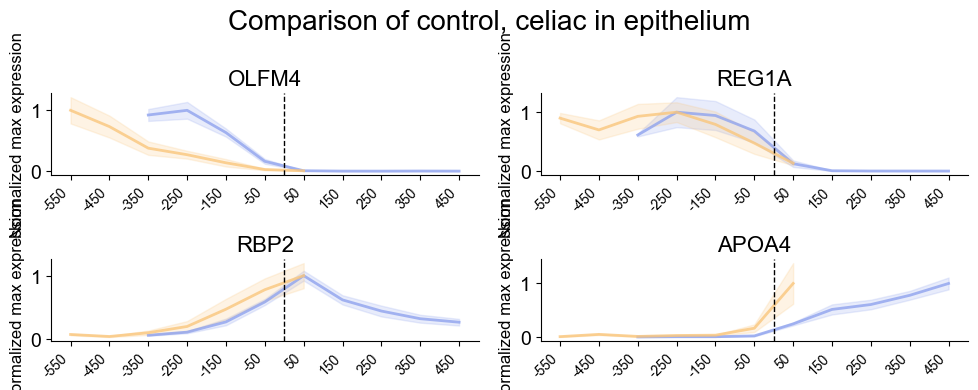

In [23]:
def plot_genes_comparison_square(group_com_dict, group_list, my_compartment, genes_to_examine,
                                 color_dict, cols = None, rows=None, line_alpha=0.8, patch_alpha=0.3,
                                 figsize=None, max_normalize=False, hide_legend=False,suptitle=None):
    for my_group in group_list:
        if my_group not in group_com_dict.keys():
            print(f"{my_group} not in group_com_dict keys")
            return

    use_layer_mn ="mean_zonation"
    use_layer_se ="se_zonation"
    if max_normalize:
        use_layer_mn ="max_mean_zonation"
        use_layer_se ="max_mean_zonation_se"

    # df = group_com_dict[my_group][my_compartment][use_layer_mn].copy()

    num_genes = len(genes_to_examine)
    if (cols is None) and (rows is None):
        cols = int(np.ceil(np.sqrt(num_genes)))
        rows = int(np.ceil(num_genes / cols))
    elif (cols == 1) and (rows is None):
        rows = num_genes
    elif (rows == 1) and (cols is None):
        cols = num_genes
    if figsize is None:
        fig_height = 2
        fig_width = 5
        fig, axes = plt.subplots(rows, cols, figsize=(fig_width * cols, fig_height * rows), sharex=False, sharey=False)

    else:
        fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=False, sharey=False)

    sns.despine()
    axes = np.array(axes).flatten()  # Flatten axes for easy iteration

    pooled_xtikcs = []

    for ax, gg in zip(axes, genes_to_examine):
        for my_group in group_list:
            df1 = group_com_dict[my_group][my_compartment][use_layer_mn].copy()
            df_se1 = group_com_dict[my_group][my_compartment][use_layer_se].copy()
            # x = range(len(df1.columns))
            # first_villus_index = df1.columns.get_loc(df1.columns[df1.columns.str.startswith('villus_')].tolist()[0])

            mn1 = df1.loc[gg]
            se1 = df_se1.loc[gg]

            #map mn1 index to dist_map_dict
            # mn1.index = [dist_map_dict.get(col, col) for col in mn1.index]
            # se1.index = [dist_map_dict.get(col, col) for col in se1.index]
            mn1_values_mask = ~mn1.isna()

            my_color_str = my_compartment+"_"+my_group
            my_color = color_dict.get(my_color_str, '#000000')              

            x_vec = mn1.index[mn1_values_mask]
            y_vec = mn1[mn1_values_mask]
            pos_se_vec = mn1[mn1_values_mask] + se1[mn1_values_mask]
            neg_se_vec = mn1[mn1_values_mask] - se1[mn1_values_mask]
            # print(x_vec)
            # print(pos_se_vec)
            # print(neg_se_vec)
            ax.plot(x_vec, y_vec, linewidth=2, color=my_color, label=my_group, alpha=line_alpha)
            # ax.fill_between(x, mn1 + se1, mn1 - se1, color=my_color, alpha=patch_alpha)
            ax.fill_between(x_vec, pos_se_vec.values, neg_se_vec.values, color=my_color, alpha=patch_alpha)

            # add xticks to pooled_xtikcs
            pooled_xtikcs.extend(mn1.index[mn1_values_mask].tolist())
            
        pooled_xtikcs = sorted(list(set(pooled_xtikcs)))

        ax.set_title(gg, fontsize=16)
        if max_normalize:
            ax.set_ylabel("Normalized max expression", fontsize=12)
        else:
            ax.set_ylabel("Normalized expression", fontsize=12)

        
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

        if not hide_legend:
            ax.legend(loc='best', fontsize=10)

    # Hide unused subplots
    for ax in axes[len(genes_to_examine):]:
        ax.axis('off')

    # Add x-ticks and labels to the bottom row
    for ax in axes:
        ax.set_xticks(pooled_xtikcs)
        ax.set_xticklabels(pooled_xtikcs, rotation=45, ha='right', fontsize=10)

    # change xticks to distances
    # if dist_map_dict is not None:
    #     for ax in axes:
    #         plt.sca(ax)
    #         plt.xticks(range(len(df.columns)), [dist_map_dict.get(col, col) for col in df.columns])
    #         plt.xlabel("Distance from crypt-villus border (µm)", fontsize=12)

    # Add supertitle with the compartment name, placed above the plots
    plt.subplots_adjust(top=0.88)
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=20)
    else:
        fig.suptitle(f"Comparison of {', '.join(group_list)} in {my_compartment}", fontsize=20)

    if max_normalize:
        # make yticks onlt ints
        for ax in axes:
            plt.sca(ax)
            yticks = ax.get_yticks()
            ax.set_yticks(np.arange(0, 1.1, 1))

    plt.tight_layout()
    plt.show()

# Example usage:
genes_to_examine = ["OLFM4","REG1A", "RBP2", "APOA4"]

tissue_colors_dict = {
    "epithelium_control": "#8fa3ee","epithelium_celiac": "#fac67c",#"epithelium_cv3": "#e40ed9","epithelium_cv4": "#e31a1c",
    "non_epithelium_control": "#8fa3ee","non_epithelium_celiac": "#fac67c",#"non_epithelium_cv3": "#448357","non_epithelium_cv4": "#ff7f00",
               'all_control': "#8fa3ee",'all_cecliac':"#fac67c"}#,'all_cv3':"#14CCBD",'all_cv4': "#bcbd22"}

plot_genes_comparison_square(group_com_dict, my_compartment="epithelium",
                              group_list=["control","celiac"], genes_to_examine=genes_to_examine,
                              color_dict=tissue_colors_dict, patch_alpha=0.2, line_alpha=0.8, max_normalize=True, hide_legend=True)

In [24]:
group_com_dict['control']['non_epithelium']['smoothed_mean_zonation']

,-350,-250,-150,-50,50,150,250,350,450
gene_name,,,,,,,,,
GLT1D1,0.000244,1.164317e-06,8.423693e-07,1.205846e-07,7.962272e-07,3.714554e-08,1.084952e-09,0.000000e+00,0.000000
DEFB132,0.000247,1.141840e-06,9.698298e-07,1.600907e-07,8.538355e-07,6.054338e-08,2.449158e-09,0.000000e+00,0.000000
NTRK3,0.000253,1.103592e-06,1.229338e-06,2.416227e-07,9.689885e-07,1.111840e-07,6.184916e-09,0.000000e+00,0.000000
KIRREL3,0.000266,1.072387e-06,1.620357e-06,3.693974e-07,1.136380e-06,1.940047e-07,1.432379e-08,0.000000e+00,0.000000
GRIA2,0.000286,1.098902e-06,2.124540e-06,5.475197e-07,1.339354e-06,3.096301e-07,2.978959e-08,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...
C5orf67,0.000000,2.683756e-07,3.592476e-07,5.717255e-07,8.002221e-07,9.394560e-07,1.743370e-06,2.520899e-06,0.000051
VSIG1,0.000000,1.445208e-07,2.245959e-07,3.658938e-07,5.723165e-07,7.427104e-07,1.472957e-06,1.946566e-06,0.000044
IQCA1L,0.000000,7.028096e-08,1.285680e-07,2.190892e-07,3.825352e-07,5.641148e-07,1.190201e-06,1.379188e-06,0.000038


1.2619326393093238
1.0131409978775539


(<Figure size 500x250 with 1 Axes>,
 <Axes: title={'center': 'Gene Expression in control (epithelium)'}, xlabel='Distance from crypt-villus border (µm)', ylabel='Normalized Expression'>)

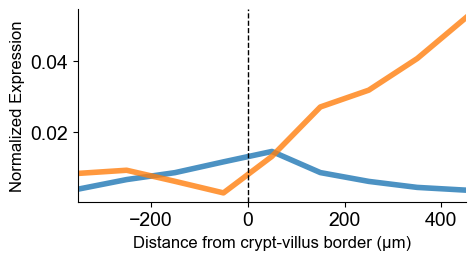

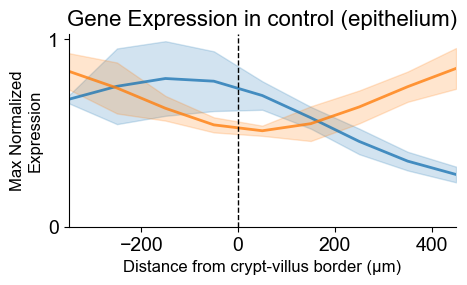

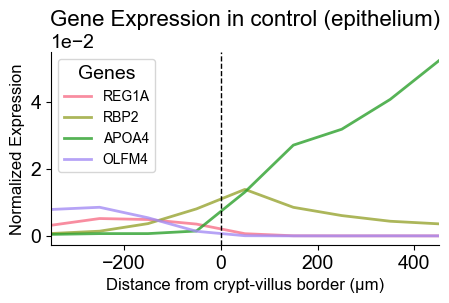

In [25]:
def plot_genes_single_axes(group_com_dict, group, my_compartment, genes_to_examine,linewidth=2, exp_yticks=False,
    color_dict=None, line_alpha=0.8, patch_alpha=0.3, figsize=(5, 2.5), show_sem = False, scaled_expression = False,
    show_sum=False, sum_legend_name=None, show_legend=False, legend_title=None, max_normalize=False, title=None, 
    exp_path=None, smooth=False,xlim=None,ax=None, show_xlabel=True):

    if group not in group_com_dict.keys():
        print(f"{group} not in group_com_dict keys")
        return

    use_layer_mn ="mean_zonation"
    use_layer_se ="se_zonation"
    # if smooth:
    #     use_layer_mn = "smoothed_mean_zonation"

    if max_normalize:
        use_layer_mn ="max_mean_zonation"
        use_layer_se ="max_mean_zonation_se"
        # if smooth:
        #     use_layer_mn = "max_smoothed_mean_zonation"

    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    df = group_com_dict[group][my_compartment][use_layer_mn].copy()
    df_se = group_com_dict[group][my_compartment][use_layer_se].copy()
    # # Apply max normalization if the flag is set
    # if max_normalize:
    #     df = df.div(df.max(axis=1), axis=0)
    #     df_se = df_se.div(df.max(axis=1), axis=0)

    if color_dict is None:
        color_dict = dict()
        dict(zip(genes_to_examine, sns.color_palette("husl", n_colors=len(genes_to_examine)).as_hex()))

    x = df.columns.tolist()
    x = [int(item) for item in x] # make sure it is ints


    # Identify first villus to add a line of separation between crypt and villus
    # first_villus_index = df.columns.get_loc(df.columns[df.columns.str.startswith('villus_')].tolist()[0])

    if show_sum:
        if isinstance(genes_to_examine, dict):
            for key, gene_list in genes_to_examine.items():
                summed_mn = df.loc[gene_list].sum(axis=0, skipna=False)
                summed_se = np.sqrt((df_se.loc[gene_list] ** 2).sum(axis=0))

                if max_normalize: #and max_max_normalize:
                    max_factor = summed_mn.max()
                    print(max_factor)
                    summed_mn = summed_mn / max_factor
                    summed_se = summed_se / max_factor

                if scaled_expression:
                    summed_mn = summed_mn - summed_mn.min()
                    max_factor = summed_mn.max()
                    summed_mn = summed_mn / max_factor
                    summed_se = summed_se / max_factor

                my_color = color_dict.get(key, '#000000') if color_dict else '#000000'

                legend_name = sum_legend_name[key] if sum_legend_name is not None else f"{key}"

                if smooth:
                    summed_mn = gaussian_filter1d(summed_mn.values, sigma=smooth, mode='nearest')

                ax.plot(x, summed_mn, linewidth=linewidth, label=legend_name, alpha=line_alpha, color=my_color)
                if show_sem:
                    ax.fill_between(x, summed_mn + summed_se, summed_mn - summed_se, color=my_color, alpha=patch_alpha)
        else:
            summed_mn = df.loc[genes_to_examine].sum(axis=0, skipna=False)
            summed_se = np.sqrt((df_se.loc[genes_to_examine] ** 2).sum(axis=0))

            if max_normalize: #and max_max_normalize:
                summed_mn = summed_mn / summed_mn.max()
                summed_se = summed_se / summed_mn.max()

            if scaled_expression:
                summed_mn = summed_mn - summed_mn.min()
                summed_mn = summed_mn / summed_mn.max()
                summed_se = summed_se / summed_mn.max()

            my_color = color_dict.get(my_compartment + "_" + group, '#000000') if color_dict else '#000000'

            legend_name = sum_legend_name if sum_legend_name is not None else "Sum of markers"

            if smooth:
                summed_mn = gaussian_filter1d(summed_mn.values, sigma=smooth, mode='nearest')

            ax.plot(x, summed_mn, linewidth=linewidth, label=legend_name, alpha=line_alpha, color=my_color)
            if show_sem:
                ax.fill_between(x, summed_mn + summed_se, summed_mn - summed_se, color=my_color, alpha=patch_alpha)
    else:
        for ii,gg in enumerate(genes_to_examine):
            mn = df.loc[gg]
            se = df_se.loc[gg]

            my_color_order = sns.color_palette("husl", n_colors=len(genes_to_examine))[ii]
            my_color = color_dict.get(gg, color_dict.get(my_compartment + "_" + group, my_color_order)) if color_dict else my_color_order

            ax.plot(mn.index, mn, linewidth=linewidth, label=gg, alpha=line_alpha, color=my_color)
            if show_sem:
                ax.fill_between(x, mn + se, mn - se, color=my_color, alpha=patch_alpha)


    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

    scaled_str = "Scaled " if scaled_expression else ""

    # make yticks ints
    if max_normalize:
        ax.set_yticks(np.arange(0,1.1,1))

    if title == None:
        ax.set_title(f"Gene Expression in {group} ({my_compartment})", fontsize=16)
    else:
        ax.set_title(title)

    if show_xlabel:
        ax.set_xlabel("Distance from crypt-villus border (µm)", fontsize=12)

    if max_normalize:
        ax.set_ylabel(f"{scaled_str}Max Normalized\nExpression", fontsize=12)
    else:
        ax.set_ylabel(f"{scaled_str}Normalized Expression", fontsize=12)


    # change yticks to scientific notation if exp_yticks is True
    if exp_yticks:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


    if legend_title == None:
        legend_title = "Genes" if not show_sum else "Markers"

    if show_legend:
        ax.legend(title=legend_title, fontsize=10, loc='best')
        if show_legend=="outside":
            ax.legend(title=legend_title, fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

    sns.despine()
    if ax is None:
        fig.tight_layout()

    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(min(x), max(x))

    if (exp_path is not None) and (ax is None):
        print("Exporting to ", exp_path)
        fig.savefig(exp_path, bbox_inches="tight", pad_inches=0.02)

    return fig,ax

# Example usage:
genes_to_examine = {"Group 1": ["REG1A", "RBP2"], "Group 2": ["APOA4", "OLFM4"]}
color_dict = {"Group 1": "#1f77b4", "Group 2": "#ff7f0e", "APOA4": "#2ca02c"}
my_group = "control"
gene_list = ["REG1A", "RBP2", "APOA4", "OLFM4"]
legend_name_dict = {"Group 1": "Random group1", "Group 2": "random group2"}

plot_genes_single_axes(group_com_dict, group=my_group, my_compartment="epithelium",title="",
                       genes_to_examine=genes_to_examine, color_dict=color_dict, 
                       patch_alpha=0.2, line_alpha=0.8, show_sum=True, scaled_expression=False,
                       sum_legend_name=legend_name_dict, max_normalize=False,linewidth=4)

plot_genes_single_axes(group_com_dict, group=my_group, my_compartment="epithelium",
                       genes_to_examine=genes_to_examine, color_dict=color_dict, smooth=2,
                       patch_alpha=0.2, line_alpha=0.8, show_sum=True, show_sem=True,
                       sum_legend_name=legend_name_dict, max_normalize=True)

plot_genes_single_axes(group_com_dict, group=my_group, my_compartment="epithelium",exp_yticks=True,
                        genes_to_examine=gene_list, color_dict=color_dict,
                        patch_alpha=0.2, line_alpha=0.8, show_sum=False,
                        max_normalize=False, show_legend=True,)


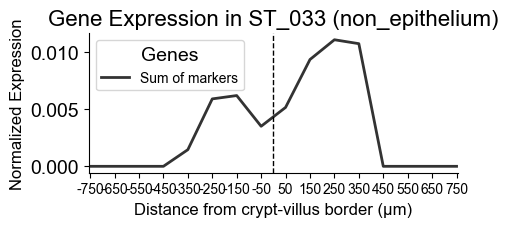

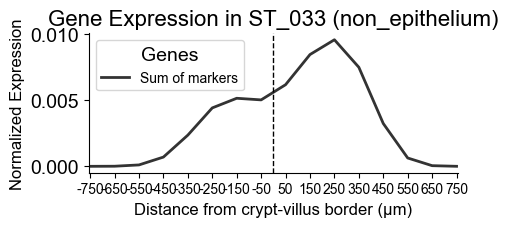

In [26]:
def plot_genes_single_axes_single_patient(pt_com_dict, pt, my_compartment, genes_to_examine,linewidth=2, exp_yticks=False, show_sum=False, max_norm_genes=False,
    color_dict=None, line_alpha=0.8, patch_alpha=0.3, figsize=(5, 2.5), show_legend=False,
     legend_title=None, title=None, dist_map_dict=dist_map_dict, smoothing_sigma=0):

    if pt not in pt_com_dict.keys():
        print(f"{pt} not in pt_com_dict keys")
        return

    plt.figure(figsize=figsize)
    df = pt_com_dict[pt][my_compartment]['mn'].copy()

    # normalize each gene to its max
    if max_norm_genes:
        df = df.div(df.max(axis=1), axis=0)

    if color_dict is None:
        color_dict = dict()
        dict(zip(genes_to_examine, sns.color_palette("husl", n_colors=len(genes_to_examine)).as_hex()))

    x = range(len(df.columns))

    # Identify first villus to add a line of separation between crypt and villus
    first_villus_index = df.columns.get_loc(df.columns[df.columns.str.startswith('villus_')].tolist()[0])

    if show_sum:
        summed_mn = df.loc[genes_to_examine].sum(axis=0, skipna=True)

        # add smoothing to summed_mn
        if smoothing_sigma > 0:
            summed_mn = pd.Series(gaussian_filter1d(summed_mn, sigma=smoothing_sigma), index=summed_mn.index)

        my_color = color_dict.get(my_compartment + "_" + pt, '#000000') if color_dict else '#000000'

        legend_name = "Sum of markers"
        plt.plot(x, summed_mn, linewidth=linewidth, label=legend_name, alpha=line_alpha, color=my_color)
    else:
        for ii,gg in enumerate(genes_to_examine):
            mn = df.loc[gg]

            my_color_order = sns.color_palette("husl", n_colors=len(genes_to_examine))[ii]
            my_color = color_dict.get(gg, color_dict.get(my_compartment + "_" + pt, my_color_order)) if color_dict else my_color_order

            plt.plot(x, mn, linewidth=linewidth, label=gg, alpha=line_alpha, color=my_color)


    plt.axvline(x=first_villus_index - 0.5, color='black', linestyle='--', linewidth=1)

    if title == None:
        plt.title(f"Gene Expression in {pt} ({my_compartment})", fontsize=16)
    else:
        plt.title(title)

    plt.xlabel("Distance from crypt-villus border (µm)", fontsize=12)
    plt.ylabel(f"Normalized Expression", fontsize=12)

    # change xticks to distances
    if dist_map_dict is not None:
        plt.xticks(range(len(df.columns)), [dist_map_dict.get(col, col) for col in df.columns], fontsize=10)

    # change yticks to scientific notation if exp_yticks is True
    if exp_yticks:
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # set x-axis limits
    min_df = 0
    max_df = len(df.columns) - 1
    xlim_buffer = 0.05
    plt.xlim(min_df - xlim_buffer, max_df + xlim_buffer)

    if legend_title == None:
        legend_title = "Genes"
    if show_legend:
        plt.legend(title=legend_title, fontsize=10, loc='best')
        if show_legend=="outside":
            plt.legend(title=legend_title, fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

    sns.despine()
    plt.tight_layout()
    plt.show()

    if show_sum:
        # change summed_mn index to distances
        summed_mn.index = [dist_map_dict.get(col, col) for col in df.columns]
        return summed_mn


# Example usage:
genes_to_examine = ["OLFM4","APOA4"]
# color_dict = {"REG1A": "#1f77b4", "RBP2": "#ff7f0e", "APOA4": "#2ca02c", "OLFM4": "#d62728"}
my_pt = "ST_033"
summed_df = plot_genes_single_axes_single_patient(pt_com_dict, pt=my_pt, my_compartment="non_epithelium",
                       genes_to_examine=genes_to_examine, smoothing_sigma=0,
                       patch_alpha=0.2, line_alpha=0.8, show_legend=True,show_sum=True)
summed_df = plot_genes_single_axes_single_patient(pt_com_dict, pt=my_pt, my_compartment="non_epithelium",
                       genes_to_examine=genes_to_examine, smoothing_sigma=1,
                       patch_alpha=0.2, line_alpha=0.8, show_legend=True,show_sum=True)

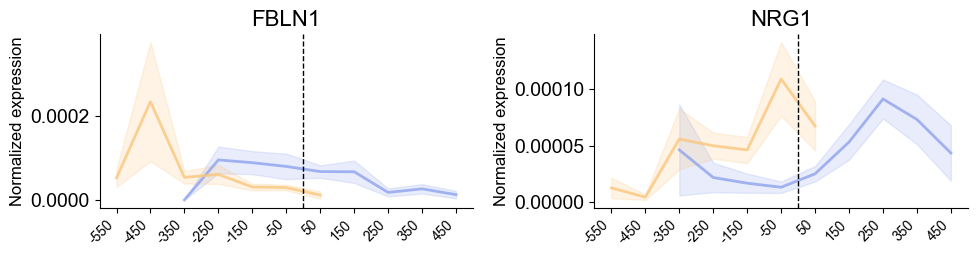

In [27]:
genes_to_examine = ["FBLN1", "NRG1"]

plot_genes_comparison_square(group_com_dict, my_compartment="non_epithelium",figsize=(10,3),suptitle="",
                              group_list=["control","celiac"], genes_to_examine=genes_to_examine,#max_normalize=True,
                              color_dict=tissue_colors_dict, patch_alpha=0.2, line_alpha=0.8, hide_legend=True)

(<Figure size 500x200 with 1 Axes>,
 <Axes: xlabel='Distance from crypt-villus border (µm)', ylabel='Max Normalized\nExpression'>)

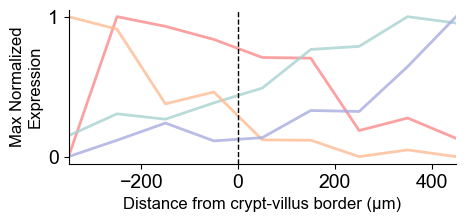

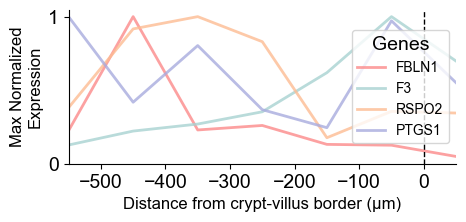

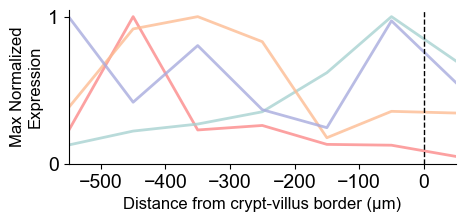

In [28]:
# Example usage:
# genes_to_examine = ["FBLN1", "F3"]
color_dict = {"FBLN1": "#fc8a8a","RSPO2":"#fdbc93", "F3": "#a8d2d1","PTGS1":"#a8abde"}
my_group = "control"
gene_list = ["FBLN1", "F3","RSPO2","PTGS1"]
my_figsize = (5, 2)

plot_genes_single_axes(group_com_dict, group=my_group, my_compartment="non_epithelium",
                        genes_to_examine=gene_list, color_dict=color_dict,
                        patch_alpha=0.2, line_alpha=0.8, show_sum=False,
                        max_normalize=True, show_legend=False, title="", figsize=my_figsize)
my_group = "celiac"
plot_genes_single_axes(group_com_dict, group=my_group, my_compartment="non_epithelium",
                        genes_to_examine=gene_list, color_dict=color_dict,
                        patch_alpha=0.2, line_alpha=0.8, show_sum=False,
                        max_normalize=True, show_legend=True, title='', figsize=my_figsize)
plot_genes_single_axes(group_com_dict, group=my_group, my_compartment="non_epithelium",
                        genes_to_examine=gene_list, color_dict=color_dict,
                        patch_alpha=0.2, line_alpha=0.8, show_sum=False,
                        max_normalize=True, show_legend=False, title='', figsize=my_figsize)

In [29]:
# fib_ad = sc_ad[sc_ad.obs['cell_type_lvl2'].isin(['Crypt_telocytes','Tip_telocytes',"Myofibroblasts"])]#'Fibroblasts',
fib_ad = sc_ad[sc_ad.obs['cell_type_lvl1'].isin(['Stroma'])]#'Fibroblasts',
fib_ad

View of AnnData object with n_obs × n_vars = 3026 × 18129
    obs: 'sample_name', 'batch', 'clinical_group', 'processing_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'log10_total_counts', 'leiden', 'cell_type_lvl1', 'cell_type_lvl2', 'epi_umap1', 'epi_umap2', 'entero_umap1', 'entero_umap2', 'stroma_umap1', 'stroma_umap2', 'epi_leiden', 'stroma_leiden', 'imm_leiden', 'stroma_umap_1', 'stroma_umap_2', 'immune_umap_1', 'immune_umap_2'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells_by_

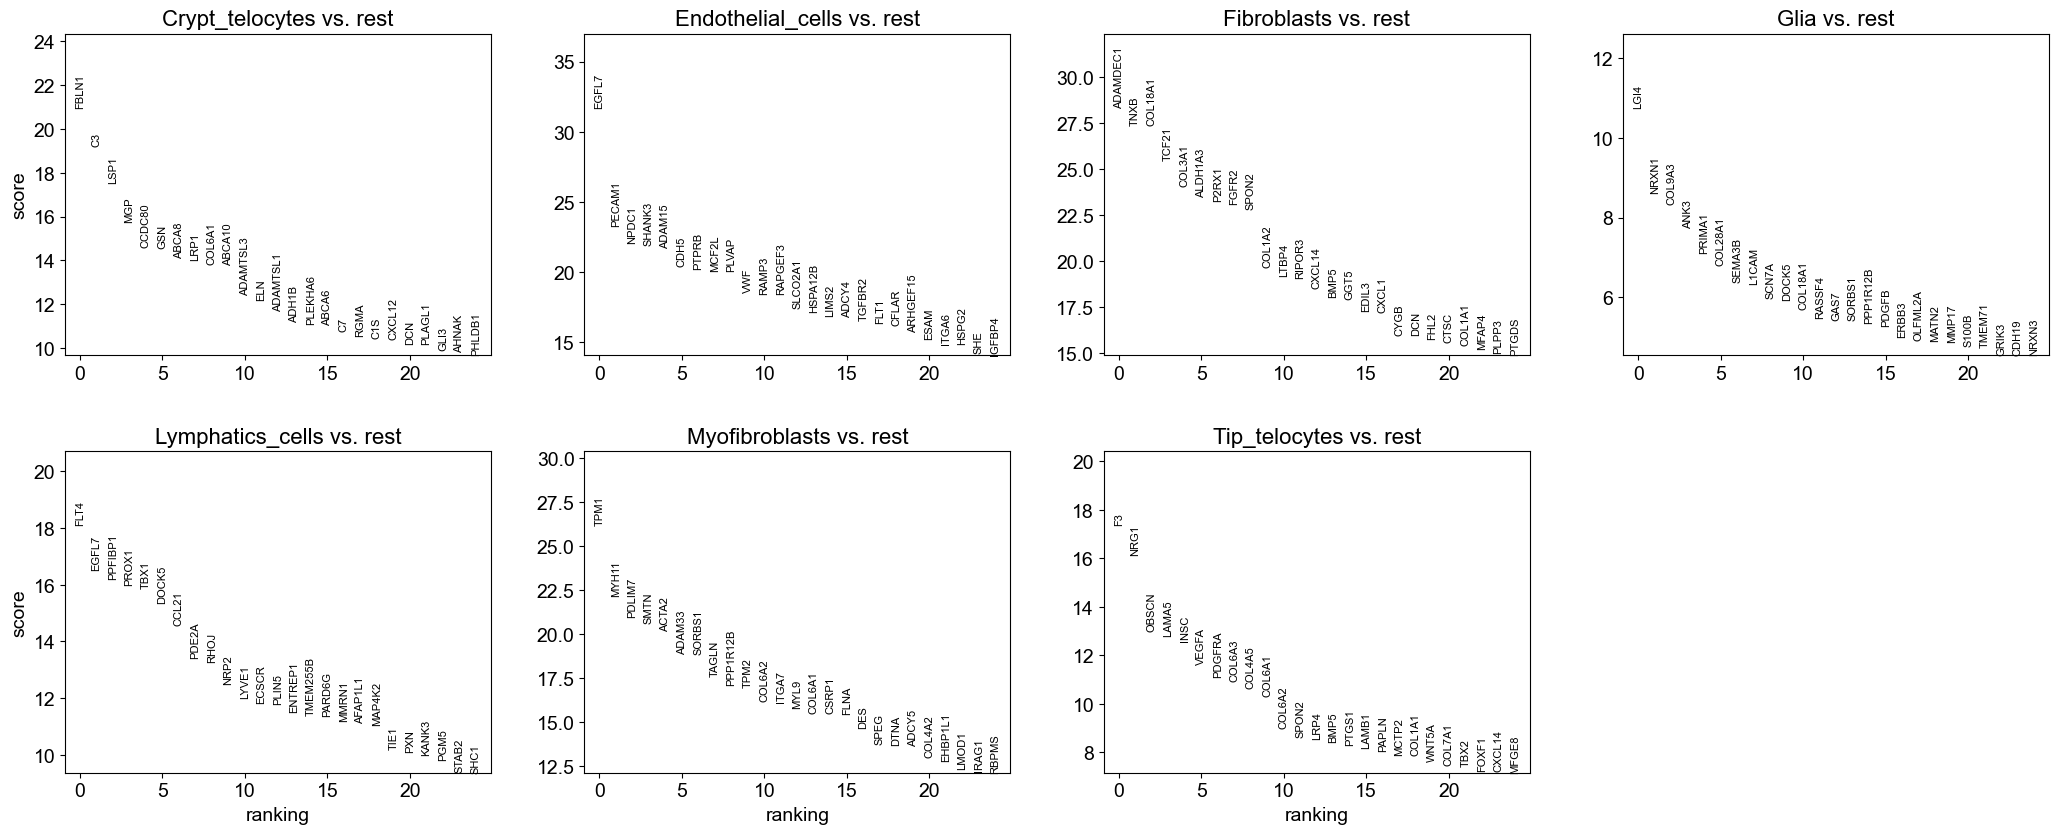

In [30]:
sc.tl.rank_genes_groups(fib_ad, groupby='cell_type_lvl2', method='wilcoxon')
sc.pl.rank_genes_groups(fib_ad, n_genes=25, sharey=False)

### Select n_markers of stromal compartment

In [31]:
MIN_EXP = 1e-5
control_non_epi_com_path = os.getcwd()+"/group_com_zonation/group_com_zonation_control_non_epithelium.csv"
com_df = pd.read_csv(control_non_epi_com_path, index_col=0)
com_df_filtered = com_df.loc[:,com_df.columns.str.contains("_mean")]

# sum normalize each 
mx = com_df_filtered.max(axis=1)
# create scatter_df with com_df_filtered.mean(axis=1) as 'mean_non_epithelium_exp' and com_df.loc[:,'com']
scatter_df = pd.DataFrame({
    'mean_non_epithelium_exp':com_df_filtered.mean(axis=1),
    'log10_mean_non_epithelium_exp': np.log10(com_df_filtered.mean(axis=1) + 1e-6),
    'com': com_df.loc[:,'com_01'],
    'selected':False
})

scatter_df = scatter_df.loc[mx > MIN_EXP]
print(len(scatter_df))

prct_low = 10
prct_high = 100-prct_low
scatter_df['percentile'] = pd.qcut(scatter_df['com'], q=100, labels=False)

# # yotam's EDF 7CD WITHOUT receptors/TFs
bmps = ['GREM1','BMP4','BMP3','GREM2','BMP6','BMP2K','BMPER','BMP2', 'BMP5','BMP7','BMP1','BMP8A','BMP8B']
wnts = ['WNT2','DKK2','SFRP4','WNT6','SFRP2','RSPO3','SFRP1','WNT9A','DKK3','RSPO2','WNT2B','WNT10B','WNT4','WNT10A','WNT5B','SFRP5','WNT3','WNT5A','WNT9B','WNT11']
morphos = [bmps+wnts]
scatter_df = scatter_df.loc[np.intersect1d(wnts+bmps, scatter_df.index.tolist())]

# starts_to_keep = ["GREM","WNT","RSPO","BMP"]
# scatter_df = scatter_df[scatter_df.index.str.startswith(tuple(starts_to_keep))]

# N=5
# top_genes = scatter_df.sort_values(by='com', ascending=False).head(N).index.tolist()
# bottom_genes = scatter_df.sort_values(by='com', ascending=True).head(N).index.tolist()
# extreme_genes = top_genes + bottom_genes
top_genes = np.intersect1d(scatter_df[scatter_df['percentile'] >= prct_high].index.tolist(), morphos).tolist()
bottom_genes = np.intersect1d(scatter_df[scatter_df['percentile'] <= prct_low].index.tolist(), morphos).tolist()
extreme_genes = top_genes + bottom_genes
scatter_df.loc[extreme_genes, 'selected'] = True

print("Selected top genes:", top_genes)
print("Selected bottom genes:", bottom_genes)

# create dataframe with top and bottom genes and export to csv
# Create a dataframe with top and bottom genes
extreme_genes_df = scatter_df.loc[extreme_genes, ['mean_non_epithelium_exp', 'log10_mean_non_epithelium_exp', 'com', 'percentile']]
extreme_genes_df['category'] = ['top' if gene in top_genes else 'bottom' for gene in extreme_genes_df.index]

# Export the dataframe to a CSV file
extreme_genes_df.to_csv("extreme_genes.csv", index_label="gene_name")

px.scatter(scatter_df, x='log10_mean_non_epithelium_exp', y='com', color='selected', hover_name=scatter_df.index)

15070
Selected top genes: ['BMP2', 'BMP2K', 'BMP5', 'BMP7', 'SFRP2', 'WNT11', 'WNT5A', 'WNT9B']
Selected bottom genes: ['GREM1', 'GREM2', 'RSPO2', 'RSPO3', 'WNT6']


### Plot crypt-tip curves

In [32]:
# if /figures/fig3/ doesnt exist - create it
fig_save_path = os.getcwd()+"/figures/fig3/"
if not os.path.exists(fig_save_path):
    os.makedirs(fig_save_path)


fig2_supp_save_path = os.getcwd()+"/figures/supp_tip_base_correlation/"
if not os.path.exists(fig2_supp_save_path):
    os.makedirs(fig2_supp_save_path)

{'RSPOs+GREMs': ['GREM1', 'GREM2', 'RSPO2', 'RSPO3', 'WNT6'], 'BMPs': ['BMP2', 'BMP2K', 'BMP5', 'BMP7', 'SFRP2', 'WNT11', 'WNT5A', 'WNT9B']}


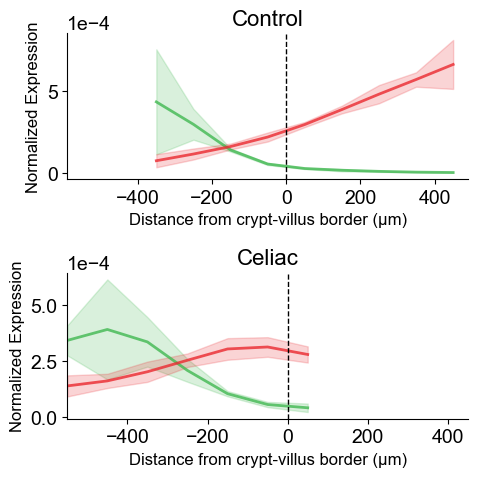

In [33]:
genes_to_examine = {"RSPOs+GREMs":bottom_genes,"BMPs":top_genes}
color_dict = {"RSPOs+GREMs": "#41b851", "BMPs":"#ea292f", "Tip markers":"#41b851"}

print(genes_to_examine)
max_norm = False
show_sem = True
smooth_param = 1
my_group = "control"
my_compartment = "non_epithelium"
legend_name_dict = {"RSPOs+GREMs": "Crypt\nmorphogenes", "BMPs":"Villus tip\nmorphogenes",}

fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=False)
ct_fig, ct_ax = plot_genes_single_axes(group_com_dict, group=my_group, my_compartment=my_compartment,
                    linewidth=2,exp_yticks=True, smooth=smooth_param,
                    genes_to_examine=genes_to_examine, color_dict=color_dict, max_normalize=max_norm, title=my_group.capitalize(),show_sem=show_sem,
                    patch_alpha=0.2, line_alpha=0.8, show_sum=True, figsize=(5,2.5),sum_legend_name=legend_name_dict, show_legend=False,
                    xlim=(-590,490),exp_path=f"{fig_save_path}/Fig3C_zonation_plot_sum_RSPOS_GREM_BMPs_control.pdf",
                    ax=axes[0])
# remove x axis labels for top plot
# ct_ax.set_xlabel("")

my_group = "celiac"
ced_fig, ced_ax = plot_genes_single_axes(group_com_dict, group=my_group, my_compartment=my_compartment,
                    linewidth=2,exp_yticks=True,smooth=smooth_param,
                    genes_to_examine=genes_to_examine, color_dict=color_dict, max_normalize=max_norm, title=my_group.capitalize(),show_sem=show_sem,
                    patch_alpha=0.2, line_alpha=0.8, show_sum=True, figsize=(5,2.5),sum_legend_name=legend_name_dict, show_legend=False, legend_title="",
                    xlim=(-550,450),exp_path=f"{fig_save_path}/Fig3D_zonation_plot_sum_RSPOS_GREM_BMPs_celiac.pdf",
                    ax=axes[1])
fig.tight_layout()
fig.savefig(f"{fig_save_path}/Fig3C_D_zonation_plot_sum_RSPOS_GREM_BMPs_control_celiac.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

OLFM in control

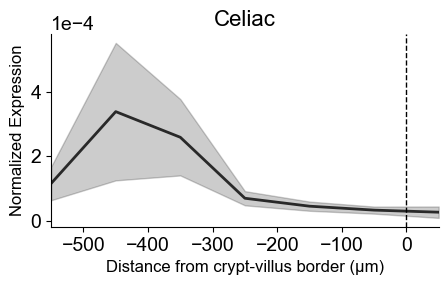

In [34]:
my_compartment = "non_epithelium"
legend_name_dict = {"RSPOs+GREMs": "Crypt\nmorphogenes", "BMPs":"Villus tip\nmorphogenes", }
# genes_to_examine = {"RSPOs+GREMs":["RSPO2","RSPO3","WNT9A","SFRP1","GREM1","GREM2"],
# "BMPs":["OLFM4"]}
my_group = 'celiac'
my_fig = plot_genes_single_axes(group_com_dict, group=my_group, my_compartment=my_compartment,linewidth=2,exp_yticks=True, 
                       genes_to_examine=["MYH11"], max_normalize=max_norm, title=my_group.capitalize(),show_sem=show_sem,
                       patch_alpha=0.2, line_alpha=0.8, show_sum=True, figsize=(5,2.5),sum_legend_name=legend_name_dict, show_legend=False,
                       exp_path=None)

### calcualte per patient crypt-tip peaks differences

In [35]:
def calculate_vector_com(my_vec):
    #calculate center of mass
    # drop zeros
    my_vec = my_vec[my_vec > 0]
    # my_vec.index = range(1,len(my_vec)+1)
    # calcualte center of mass
    my_vec_com = np.sum(my_vec.index.astype(float) * my_vec.values) / np.sum(my_vec.values)
    # normalize to length of vector
    # my_vec_com = my_vec_com / (len(my_vec))
    return my_vec_com

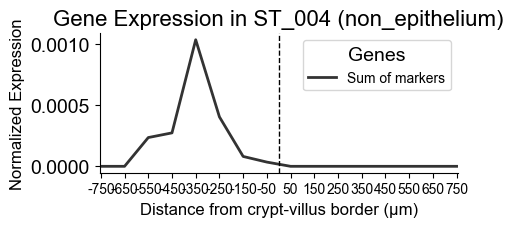

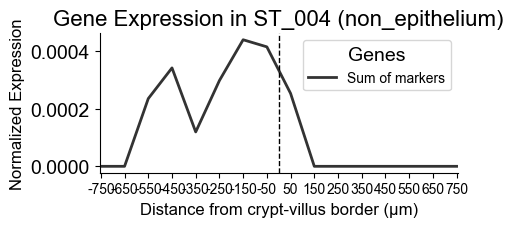

ST_004 celiac diff:200 peak_top:-150 peak_bottom:-350


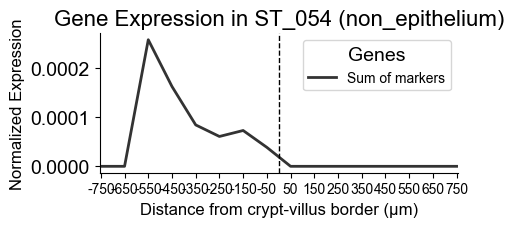

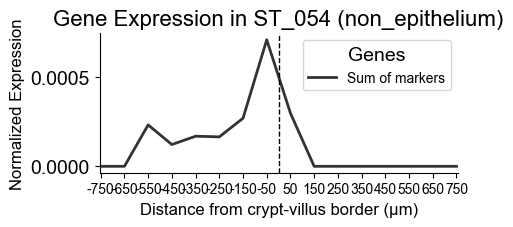

ST_054 celiac diff:500 peak_top:-50 peak_bottom:-550


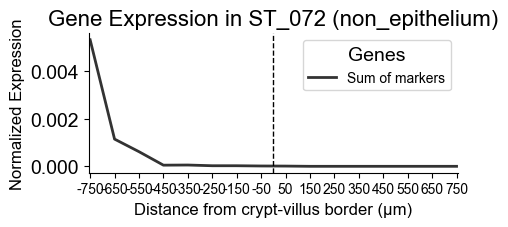

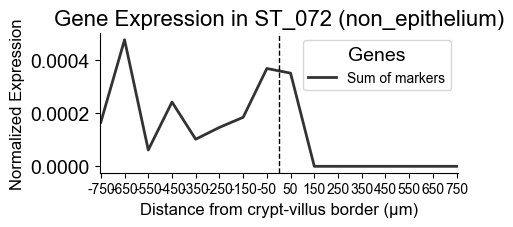

ST_072 celiac diff:100 peak_top:-650 peak_bottom:-750


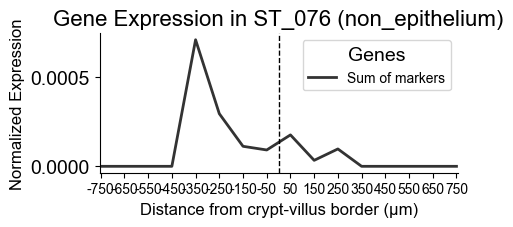

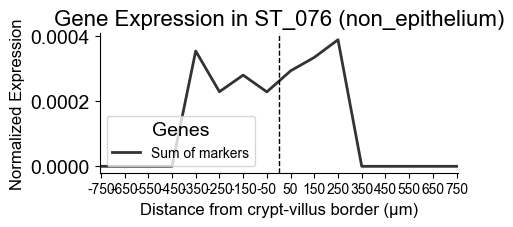

ST_076 celiac diff:600 peak_top:250 peak_bottom:-350


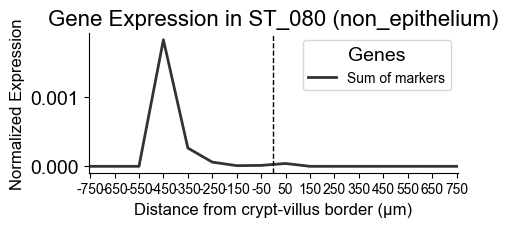

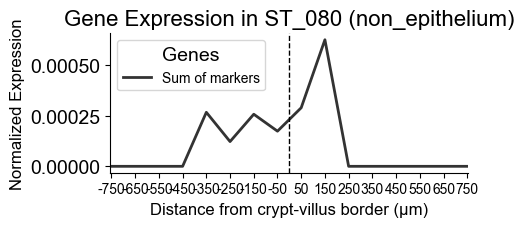

ST_080 celiac diff:600 peak_top:150 peak_bottom:-450


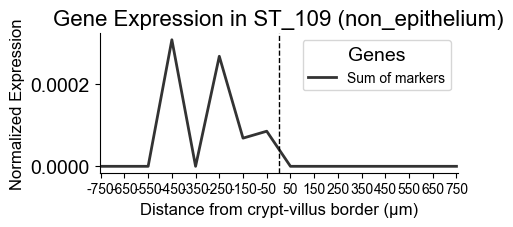

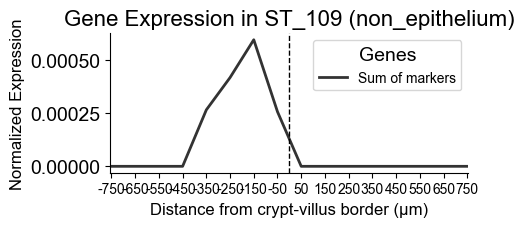

ST_109 celiac diff:300 peak_top:-150 peak_bottom:-450


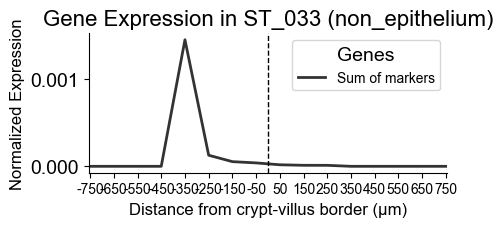

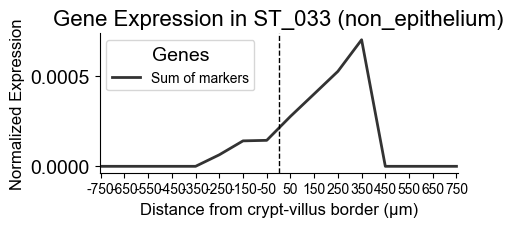

ST_033 control diff:700 peak_top:350 peak_bottom:-350


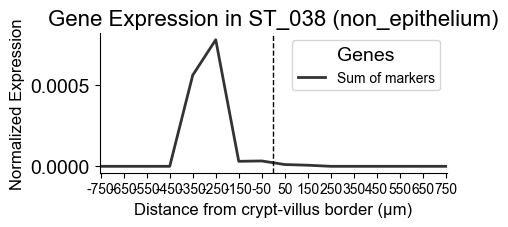

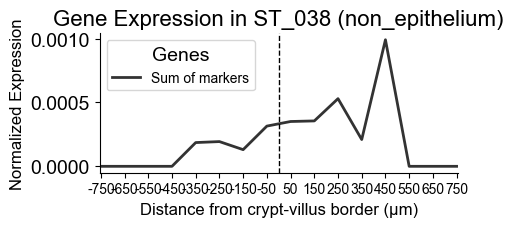

ST_038 control diff:700 peak_top:450 peak_bottom:-250


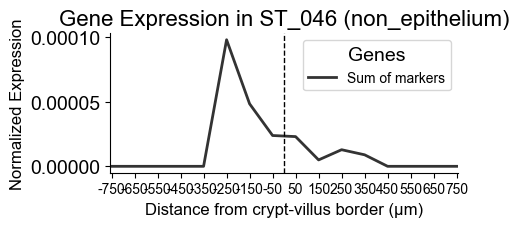

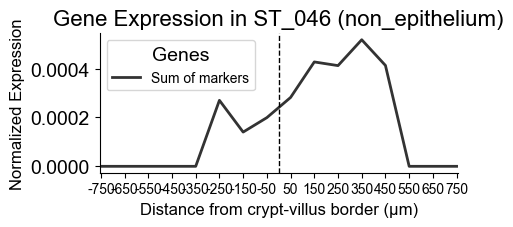

ST_046 control diff:600 peak_top:350 peak_bottom:-250


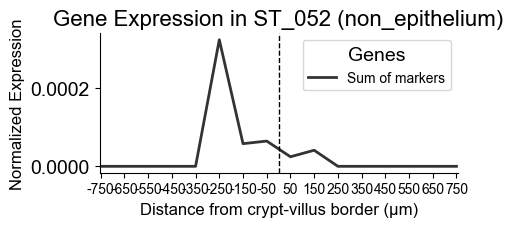

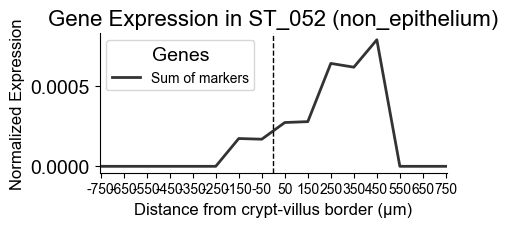

ST_052 control diff:700 peak_top:450 peak_bottom:-250


In [36]:
smoothing_sigma = 0
top_base_diff_df = []
for group in ['celiac', 'control']:
    patients = all_ad.obs.loc[all_ad.obs['group'] == group]['pt'].unique().tolist()
    patients = np.intersect1d(patients, list(pt_com_dict.keys()))
    for pt in patients:
        # plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
        #                     genes_to_examine=['OLFM4'], max_norm_genes=False, smoothing_sigma=smoothing_sigma,
        #                     patch_alpha=0.2, line_alpha=0.8, show_legend=True, show_sum=True,title='OLFM4')

        bottom_vec = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
                           genes_to_examine=bottom_genes, max_norm_genes=False, smoothing_sigma=smoothing_sigma,
                           patch_alpha=0.2, line_alpha=0.8, show_legend=True, show_sum=True)
        peak_index_bottom = bottom_vec.idxmax()
        #calculate center of mass
        bottom_vec_com = calculate_vector_com(bottom_vec)

        top_vec = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
                           genes_to_examine=top_genes, max_norm_genes=False, smoothing_sigma=smoothing_sigma,
                           patch_alpha=0.2, line_alpha=0.8, show_legend=True, show_sum=True)
        peak_index_top = top_vec.idxmax()
        #calculate center of mass
        top_vec_com = calculate_vector_com(top_vec)


        peak_diff = peak_index_top - peak_index_bottom
        com_diff = top_vec_com - bottom_vec_com

        top_base_diff_df.append({'pt': pt, 'group': group, 'peak_index_top': peak_index_top, 'peak_index_bottom': peak_index_bottom, 'peak_diff': peak_diff,
                                 'top_vec_com': top_vec_com, 'bottom_vec_com': bottom_vec_com, 'com_diff': com_diff})
        print(pt + " " +group+ " diff:" +str(peak_diff) + " peak_top:" + str(peak_index_top) + " peak_bottom:" + str(peak_index_bottom))

# Convert the list of dictionaries to a DataFrame
top_base_diff_df = pd.DataFrame(top_base_diff_df)
# for pt in control_patients:
#     print(pt)
#     peak_index_bottom = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
#                        genes_to_examine=bottom_genes, 
#                        patch_alpha=0.2, line_alpha=0.8, show_legend=True,show_sum=True).idxmax()
#     peak_index_top = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
#                        genes_to_examine=top_genes, 
#                        patch_alpha=0.2, line_alpha=0.8, show_legend=True,show_sum=True).idxmax()
#     peak_diff = peak_index_top - peak_index_bottom
#     top_base_diff_df = top_base_diff_df.append({'pt':pt,'group':'control','peak_index_top':peak_index_top,'peak_index_bottom':peak_index_bottom,'peak_diff':

# print(f"Control patients: {control_patients}")
# print(f"Celiac patients: {celiac_patients}")

In [37]:
# smoothing_sigma = 0
# top_base_diff_df = []
# for group in ['control']:
#     patients = all_ad.obs.loc[all_ad.obs['group'] == group]['pt'].unique().tolist()
#     patients = np.intersect1d(patients, list(pt_com_dict.keys()))
#     for pt in patients:
#         bottom_vec = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
#                            genes_to_examine=bottom_genes, max_norm_genes=False, smoothing_sigma=smoothing_sigma,
#                            patch_alpha=0.2, line_alpha=0.8, show_legend=True, show_sum=True)
#         peak_index_bottom = bottom_vec.idxmax()
#         #calculate center of mass
#         bottom_vec_com = calculate_vector_com(bottom_vec)

#         top_vec = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
#                            genes_to_examine=['OLFM4'], max_norm_genes=False, smoothing_sigma=smoothing_sigma,
#                            patch_alpha=0.2, line_alpha=0.8, show_legend=True, show_sum=True)
#         peak_index_top = top_vec.idxmax()
#         #calculate center of mass
#         top_vec_com = calculate_vector_com(top_vec)


#         peak_diff = peak_index_top - peak_index_bottom
#         com_diff = top_vec_com - bottom_vec_com

#         top_base_diff_df.append({'pt': pt, 'group': group, 'peak_index_top': peak_index_top, 'peak_index_bottom': peak_index_bottom, 'peak_diff': peak_diff,
#                                  'top_vec_com': top_vec_com, 'bottom_vec_com': bottom_vec_com, 'com_diff': com_diff})
#         print(pt + " " +group+ " diff:" +str(peak_diff) + " peak_top:" + str(peak_index_top) + " peak_bottom:" + str(peak_index_bottom))

# # Convert the list of dictionaries to a DataFrame
# top_base_diff_df = pd.DataFrame(top_base_diff_df)
# # for pt in control_patients:
# #     print(pt)
# #     peak_index_bottom = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
# #                        genes_to_examine=bottom_genes, 
# #                        patch_alpha=0.2, line_alpha=0.8, show_legend=True,show_sum=True).idxmax()
# #     peak_index_top = plot_genes_single_axes_single_patient(pt_com_dict, pt=pt, my_compartment="non_epithelium",
# #                        genes_to_examine=top_genes, 
# #                        patch_alpha=0.2, line_alpha=0.8, show_legend=True,show_sum=True).idxmax()
# #     peak_diff = peak_index_top - peak_index_bottom
# #     top_base_diff_df = top_base_diff_df.append({'pt':pt,'group':'control','peak_index_top':peak_index_top,'peak_index_bottom':peak_index_bottom,'peak_diff':

# # print(f"Control patients: {control_patients}")
# # print(f"Celiac patients: {celiac_patients}")

Ranksum test between control and celiac com_diff: stat=2.1320071635561044, p-value=0.03300625766123251


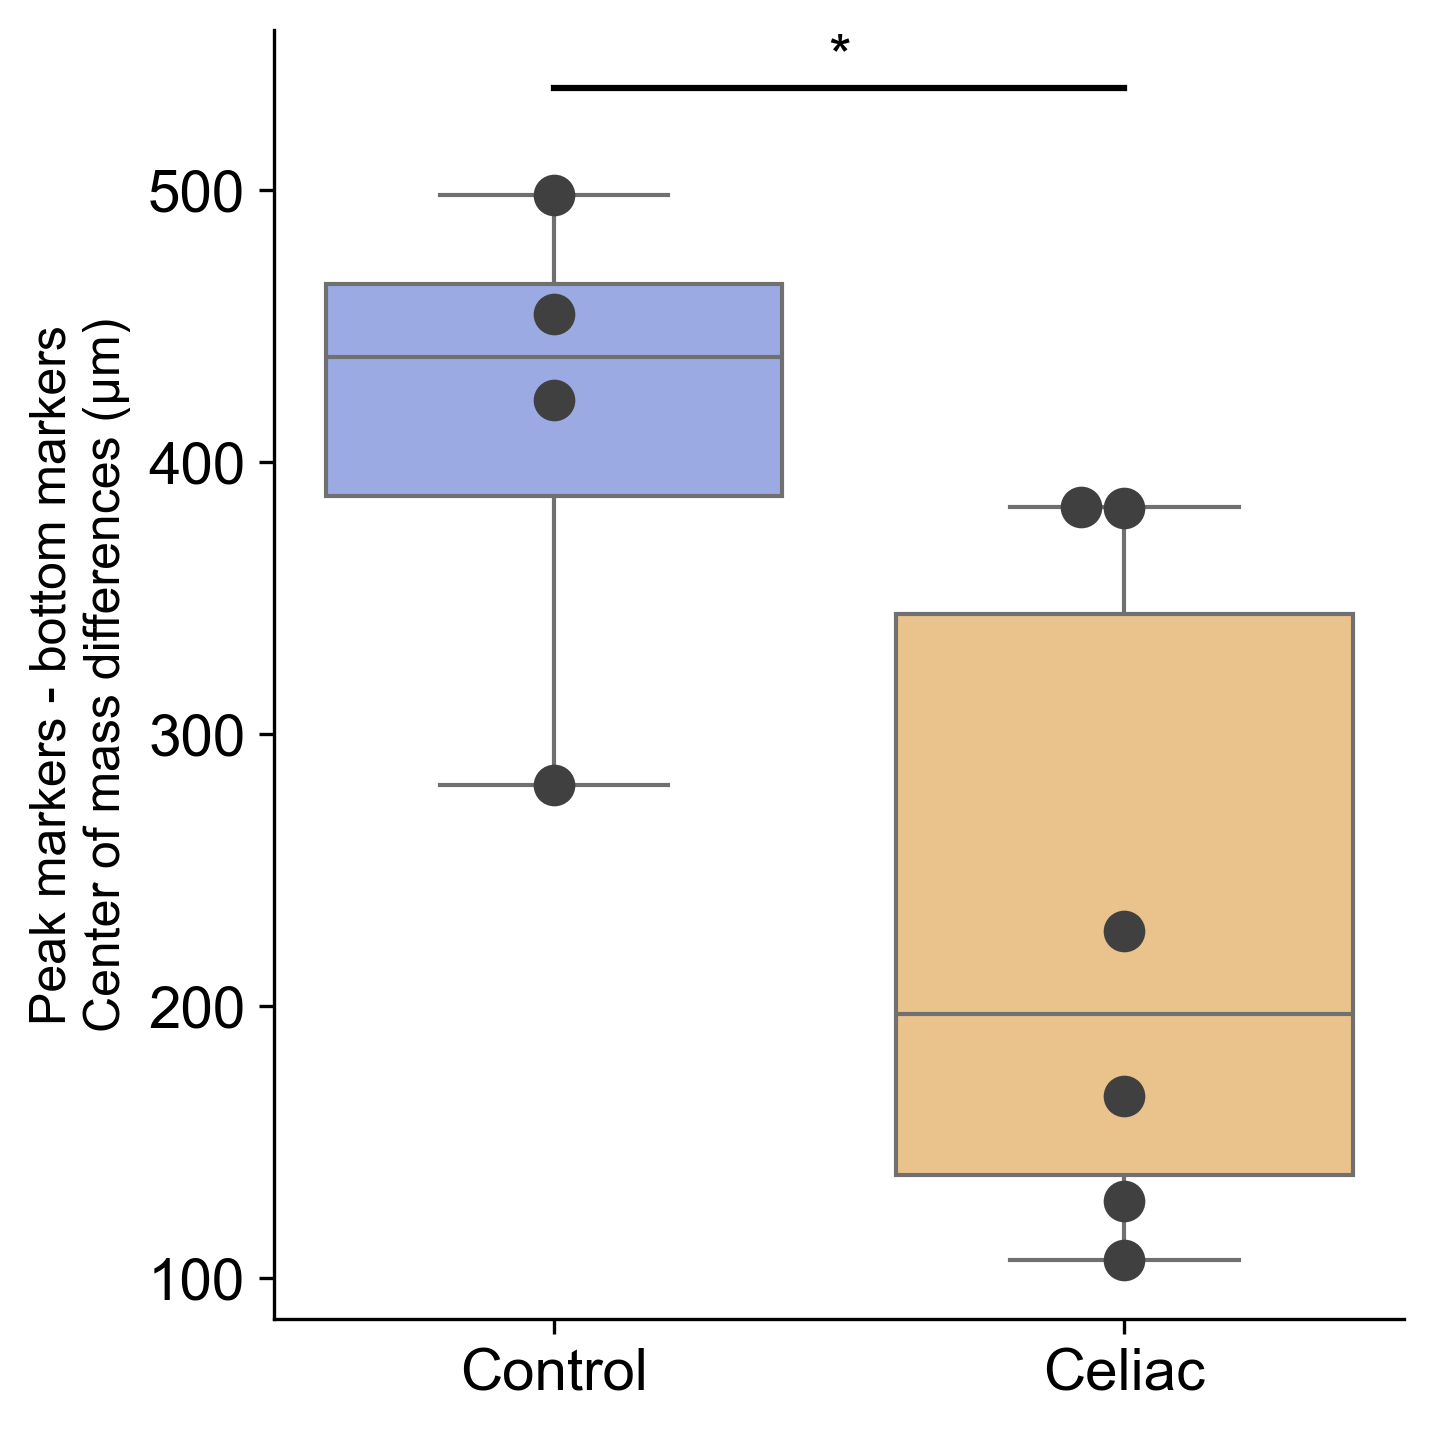

In [38]:
def plot_stat_test(data, group_col, value_col, group_order, ylabel, xlabel, title, output_path, diagnosis_palette, figsize=(5, 5), dpi=300,
                      hline = None, hline_color='black', hline_style='--',testing_method="ranksum",fig_layout="horizontal",size=10):
    """
    Perform a ranksum test and visualize the results with a boxplot and swarmplot.

    Parameters:
    - data: pandas.DataFrame, the input data containing the groups and values.
    - group_col: str, the column name for the group labels.
    - value_col: str, the column name for the values to compare.
    - group_order: list, the order of the groups for comparison.
    - ylabel: str, the label for the y-axis.
    - title: str, the title of the plot.
    - output_path: str, the path to save the figure.
    - diagnosis_palette: dict, a dictionary mapping group names to colors.
    - figsize: tuple, the size of the figure.
    - dpi: int, the resolution of the figure.
    """
    # Extract data for the two groups
    group1_data = data[data[group_col] == group_order[0]][value_col]
    group2_data = data[data[group_col] == group_order[1]][value_col]

    # Perform ranksum test
    if testing_method == "ranksum":
        stat, p_value = ranksums(group1_data, group2_data)
        print(f"Ranksum test between {group_order[0]} and {group_order[1]} {value_col}: stat={stat}, p-value={p_value}")
    elif testing_method == "ttest":
        stat, p_value = ttest_ind(group1_data, group2_data)
        print(f"T-test between {group_order[0]} and {group_order[1]} {value_col}: stat={stat}, p-value={p_value}")
    p_str = "*" if p_value < 0.05 else "n.s."

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.despine()
    if fig_layout=="horizontal":
        sns.boxplot(data=data, x=group_col, y=value_col, ax=ax, order=group_order, palette=diagnosis_palette.values())
        sns.swarmplot(data=data, x=group_col, y=value_col, color=".25", ax=ax, order=group_order, size=size)
    elif fig_layout=="vertical":
        sns.boxplot(data=data, y=group_col, x=value_col, ax=ax, order=group_order, palette=diagnosis_palette.values())
        sns.swarmplot(data=data, y=group_col, x=value_col, color=".25", ax=ax, order=group_order, size=size)

    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)

    # Add p-value to the plot
    if fig_layout=="horizontal":
        x1, x2 = 0, 1
        max_val = data[value_col].max()
        min_val = data[value_col].min()
        range_val = max_val - min_val
        y, h, col =  max_val+np.abs(range_val*0.1), np.abs(max_val*0.05), 'k'
        plt.plot([x1, x2], [y, y], lw=1.5, c=col)
        plt.text((x1 + x2) * .5, y, p_str, ha='center', va='bottom', color=col, fontsize=14)
    elif fig_layout=="vertical":
        y1,y2 = 0,1
        max_val = data[value_col].max()
        min_val = data[value_col].min()
        range_val = max_val - min_val
        x, h, col =  max_val+np.abs(range_val*0.1), np.abs(max_val*0.05), 'k'
        plt.plot([x, x], [y1, y2], lw=1.5, c=col)
        plt.text(x+h, (y1 + y2) * .65, p_str, ha='center', va='bottom', color=col, fontsize=14)

    # Add horizontal line if specified
    if hline is not None:
        plt.axhline(y=hline, color=hline_color, linestyle=hline_style)

    # Capitalize xticks
    ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
    ax.set_yticklabels([x.get_text().capitalize() for x in ax.get_yticklabels()])

    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Save the figure
    if output_path is not None:
        fig.savefig(output_path, dpi=dpi)

# Example usage:
diagnosis_palette = {"Control": "#8fa3ee", "Celiac": "#fac67c", "control": "#8fa3ee", "celiac": "#fac67c"}
plot_stat_test(
    data=top_base_diff_df,
    group_col='group',
    value_col='com_diff',
    group_order=['control', 'celiac'],
    ylabel="Peak markers - bottom markers\nCenter of mass differences (µm)",
    xlabel="",
    title="",
    testing_method="ranksum",
    figsize=(5, 5),
    diagnosis_palette=diagnosis_palette,
    output_path=f"{fig_save_path}/figure3_quantification_peak_bottom_com_diff_control_celiac.pdf"
)

In [39]:
# plot_stat_test(
#     data=top_base_diff_df,
#     group_col='group',
#     value_col='peak_index_top',
#     group_order=['control', 'celiac'],
#     ylabel="Peak Tip Markers (µm)",
#     title="",
#     output_path=f"{fig_save_path}/Figure3_quantification_peak_tip_marker.pdf",
#     hline=0,
#     diagnosis_palette=diagnosis_palette
# )

Ranksum test between control and celiac peak_diff: stat=2.345207879911715, p-value=0.019016473672300527


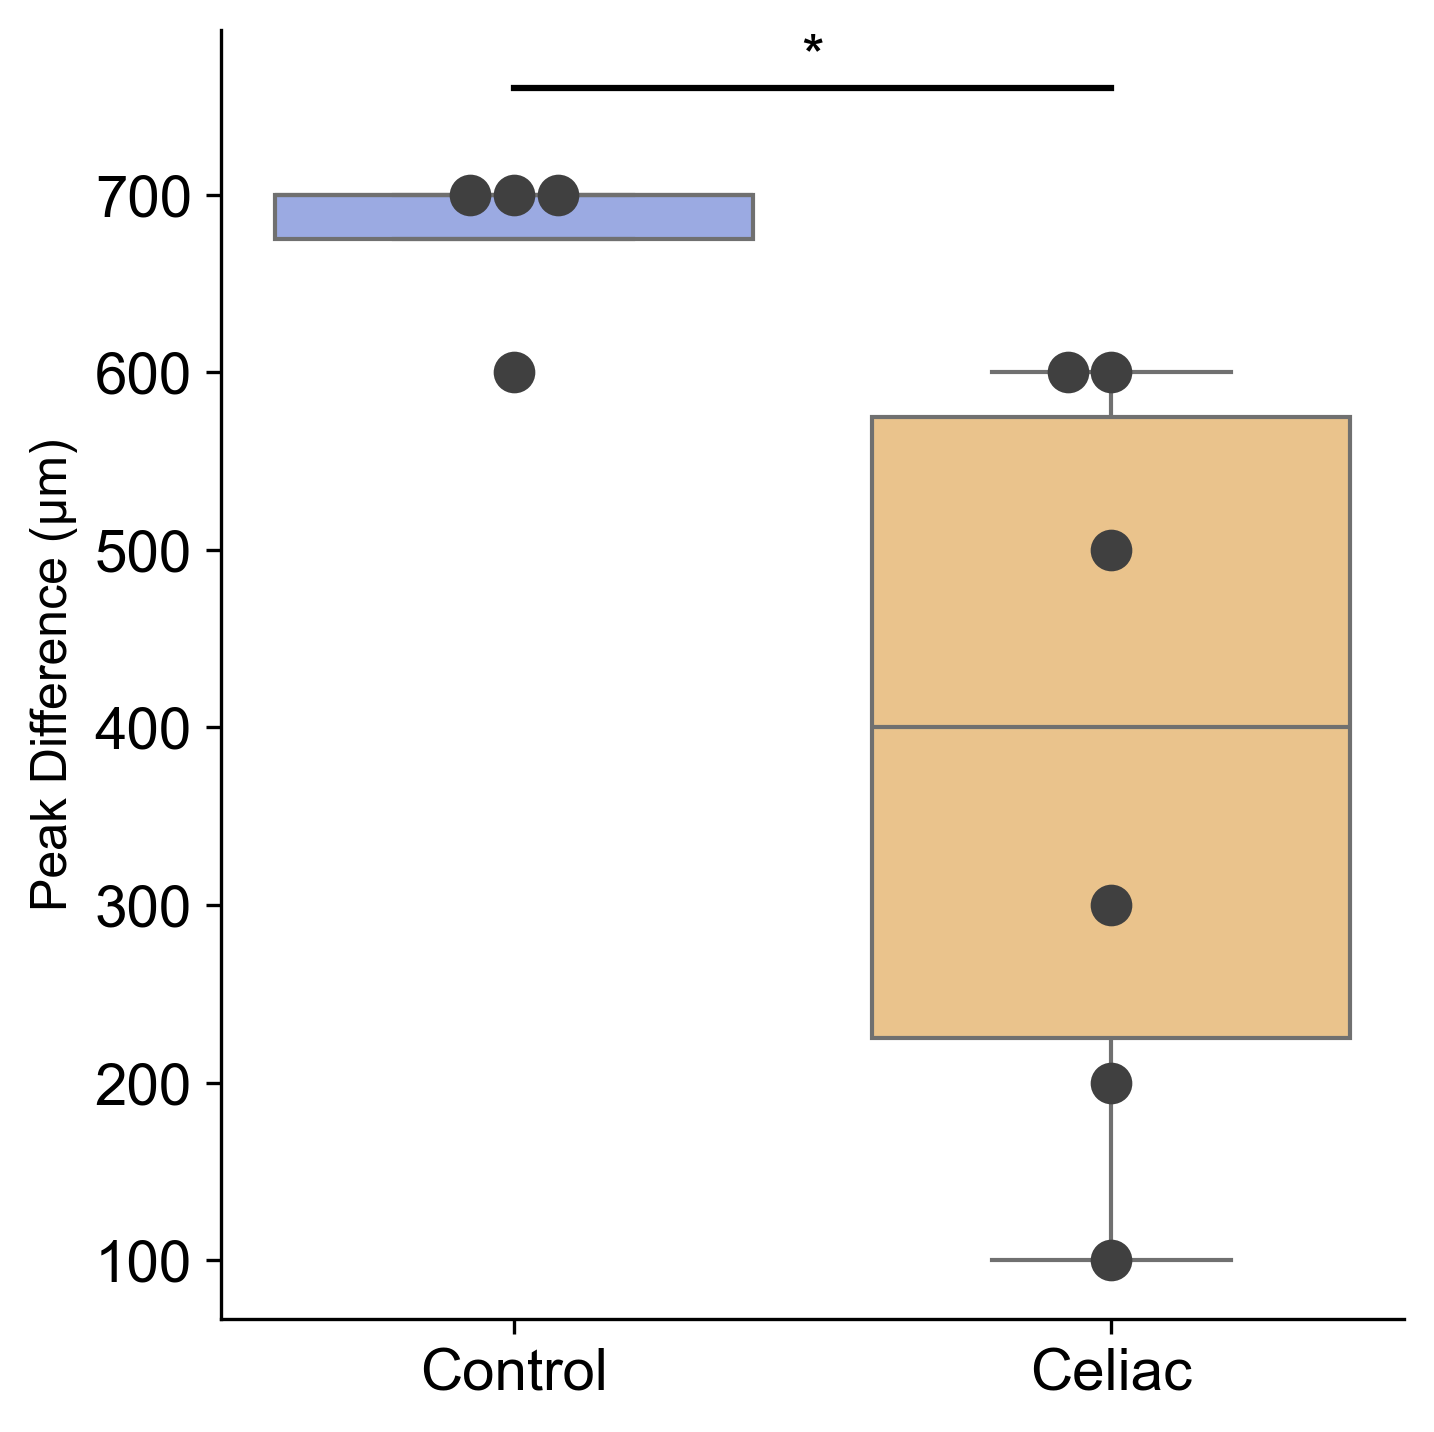

In [40]:
plot_stat_test(
    data=top_base_diff_df,
    group_col='group',
    value_col='peak_diff',
    group_order=['control', 'celiac'],
    ylabel="Peak Difference (µm)",
    xlabel="",
    title="",
    output_path=f"{fig_save_path}/Figure3_quantification_peak_diff.pdf",
    diagnosis_palette=diagnosis_palette
)

Ranksum test between control and celiac peak_diff: stat=2.345207879911715, p-value=0.019016473672300527


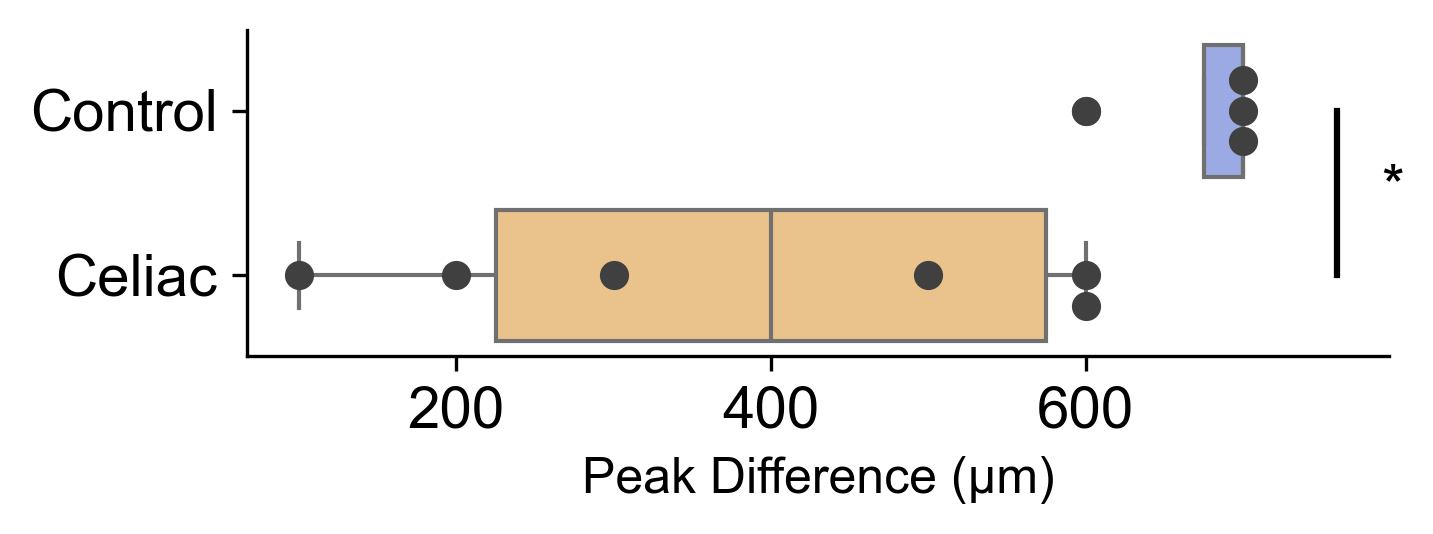

In [41]:
plot_stat_test(
    data=top_base_diff_df,
    group_col='group',
    value_col='peak_diff',
    group_order=['control', 'celiac'],
    xlabel="Peak Difference (µm)",
    ylabel="",
    title="",
    output_path=f"{fig_save_path}/Figure3_quantification_peak_diff_VERTICAL.pdf",
    diagnosis_palette=diagnosis_palette,
    fig_layout="vertical",
    size=7,
    testing_method="ranksum",
    figsize=(5, 2),
)

In [42]:
print("Control median:", top_base_diff_df.loc[top_base_diff_df['group']=='control','peak_diff'].median())
print("Celiac median:", top_base_diff_df.loc[top_base_diff_df['group']=='celiac','peak_diff'].median())
print("======================")
print("Control MEAN:", top_base_diff_df.loc[top_base_diff_df['group']=='control','peak_diff'].mean())
print("Celiac MEAN:", top_base_diff_df.loc[top_base_diff_df['group']=='celiac','peak_diff'].mean())

Control median: 700.0
Celiac median: 400.0
Control MEAN: 675.0
Celiac MEAN: 383.3333333333333


Ranksum test between control and celiac com_diff: stat=2.1320071635561044, p-value=0.03300625766123251


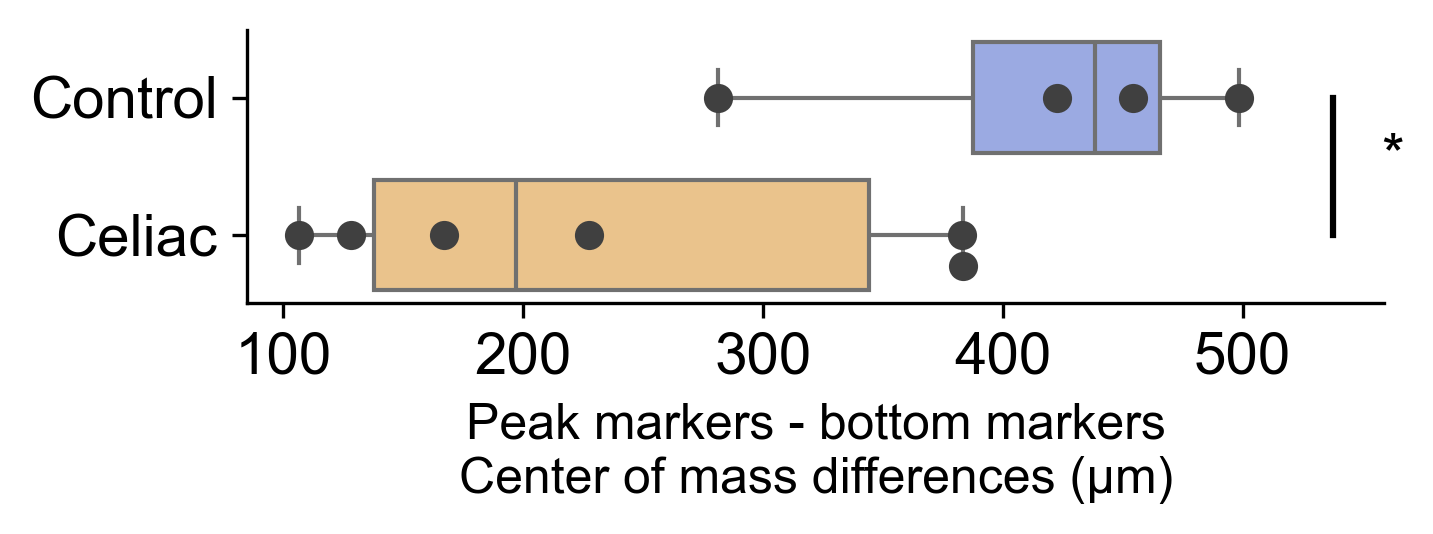

In [43]:
plot_stat_test(
    data=top_base_diff_df,
    group_col='group',
    value_col='com_diff',
    group_order=['control', 'celiac'],
    xlabel="Peak markers - bottom markers\nCenter of mass differences (µm)",
    ylabel="",
    title="",
    testing_method="ranksum",
    figsize=(5, 2),
    diagnosis_palette=diagnosis_palette,
    output_path=f"{fig_save_path}/figure3_quantification_peak_bottom_com_diff_control_celiac_VERTICAL.pdf",
    fig_layout="vertical",
    size=7
)

In [44]:
print("Control median:", top_base_diff_df.loc[top_base_diff_df['group']=='control','com_diff'].median())
print("Celiac median:", top_base_diff_df.loc[top_base_diff_df['group']=='celiac','com_diff'].median())

Control median: 438.59997285839336
Celiac median: 197.26240596091512


In [45]:
print(datetime.now())

2026-01-20 10:45:24.062539


## Compare zonation in CT and CeD

In [51]:
supp_tip_base_save_path = os.getcwd()+"/figures/supp_tip_base_correlation/"
if not os.path.exists(supp_tip_base_save_path):
    os.makedirs(supp_tip_base_save_path)

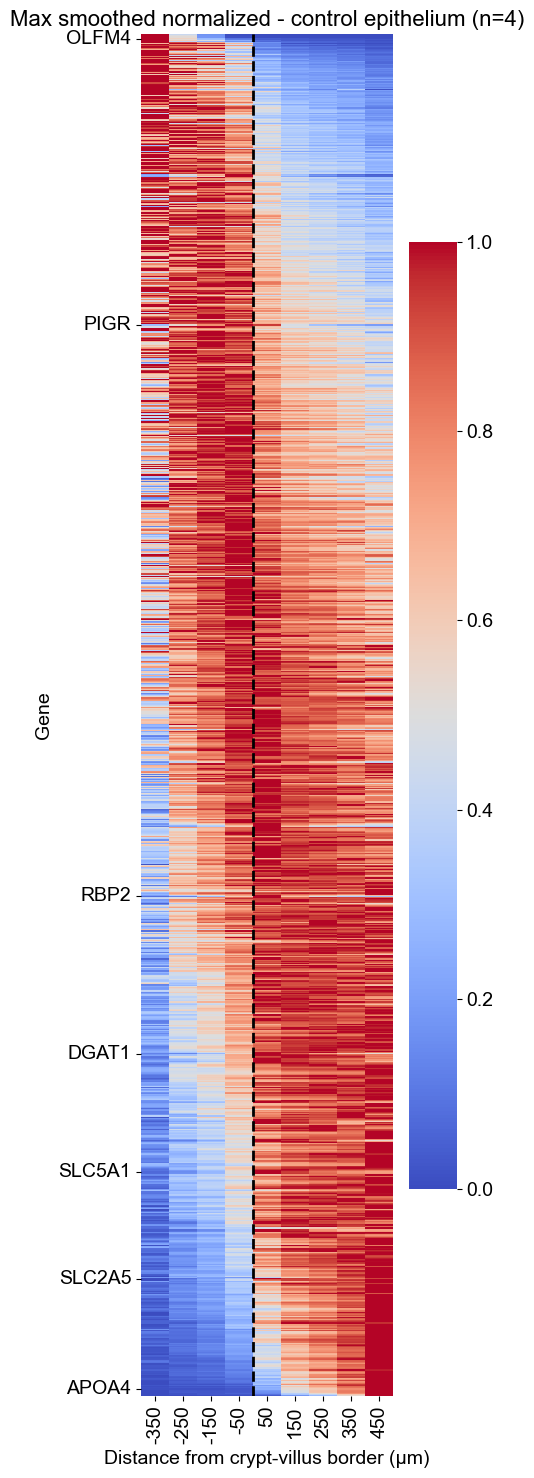

In [52]:
my_group = 'control'
compartment = 'all'
EXP_THRESH = 1e-4

def plot_cv_carpet(all_ad, group_com_dict, my_group, compartment, genes2show, EXP_THRESH=1e-4,figsize=(5,10),exp_name = None,dist_map_dict=dist_map_dict,smoothing=False,cmap='viridis'):
    if compartment == 'all':
        tmp_ad = all_ad[(all_ad.obs['group'] == my_group)*(all_ad.obs['MM_LP_crypt']+all_ad.obs['villus'])]
    else:
        tmp_ad = all_ad[(all_ad.obs['pixel_class'] == compartment)*(all_ad.obs['group'] == my_group)*(all_ad.obs['MM_LP_crypt']+all_ad.obs['villus'])]
    mean_exp = tmp_ad.layers['mat_norm'].mean(axis=0).A1
    genes_above_thresh = tmp_ad.var_names[mean_exp > EXP_THRESH]


    if smoothing:
        smooth_str = 'smoothed '
        carpet = group_com_dict[my_group][compartment]['max_smoothed_mean_zonation'].copy()
    else:
        smooth_str = ''
        carpet = group_com_dict[my_group][compartment]['max_mean_zonation'].copy()
    carpet = carpet.loc[genes_above_thresh]
    # remove nan row and columns
    carpet = carpet.dropna(axis=0, how='all')
    carpet = carpet.dropna(axis=1, how='all')

    # resort the carpet according to COM
    com = group_com_dict[my_group][compartment]['com'].loc[genes_above_thresh].copy().sort_values(ascending=True)
    carpet = carpet.loc[com.index]

    fig,ax = plt.subplots(figsize=figsize)

    # add thick line between crypt and villus
    first_villus_index = np.where(carpet.columns > 0)[0][0]#carpet.columns.get_loc(carpet.columns[carpet.columns.str.startswith('villus_')].tolist()[0])

    # rename carpet columns to distances
    carpet.columns = [dist_map_dict.get(col, col) for col in carpet.columns]

    sns.heatmap(carpet, cmap=cmap, ax=ax)

    # show only specific genes
    genes = np.intersect1d(genes_above_thresh,genes2show)
    # find the indecies of the genes in carpet
    gene_idx = [carpet.index.get_loc(gg) for gg in genes]

    ax.set_xlabel('Distance from crypt-villus border (µm)')
    ax.set_ylabel('Gene')
    ax.set_yticks(np.array(gene_idx)+0.5)
    ax.set_yticklabels(genes, rotation=0)
    ax.set_title('Max '+smooth_str+'normalized - '+my_group+' '+compartment.replace('_', '-')+' (n='+str(len(tmp_ad.obs['sample_name'].unique()))+')')
    ax.axvline(x=first_villus_index, color='black', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.show()

    if exp_name is not None:
        fig.savefig(f"{exp_name}_{my_group}_{compartment}_carpet.pdf",dpi=300)

plot_cv_carpet(all_ad, group_com_dict, my_group='control', compartment='epithelium', 
               genes2show=["OLFM4","PIGR","DGAT1","SLC5A1","RBP2","SLC2A5","APOA4"],smoothing=True,cmap='coolwarm',
               figsize=(5,15),exp_name = f"{supp_tip_base_save_path}control_carpet.pdf")

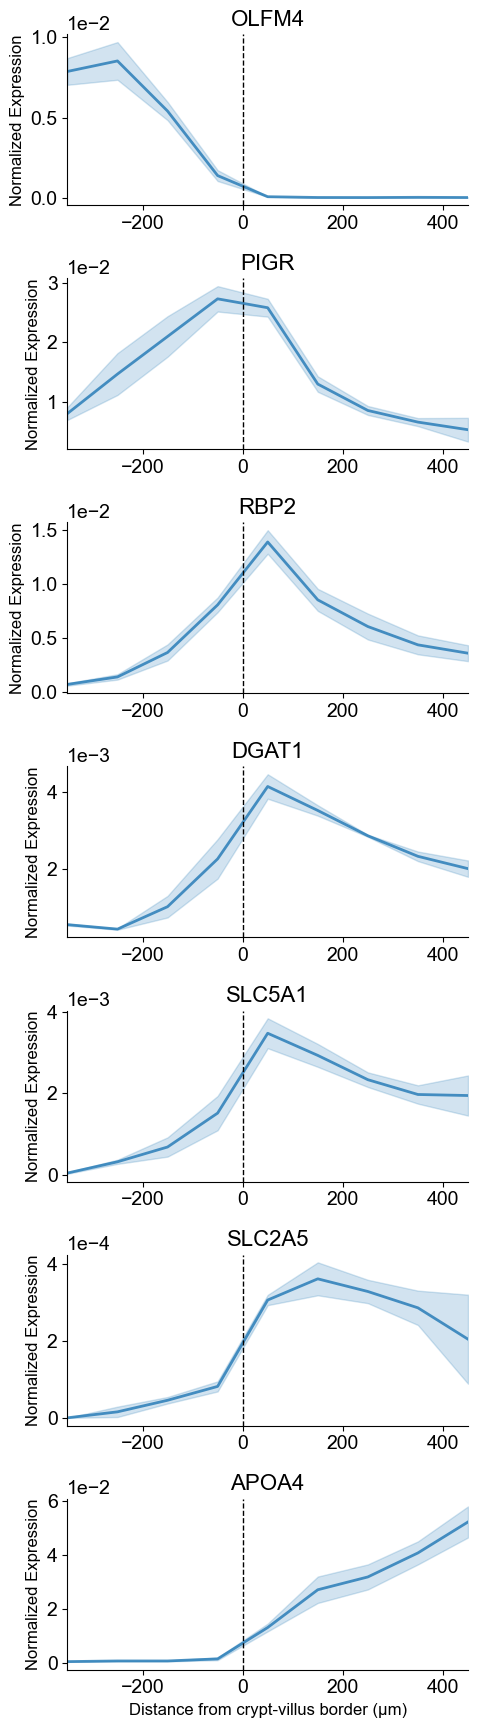

In [53]:
max_norm = True
show_sem = True
my_group = "control"
my_compartment = "epithelium"
# legend_name_dict = {"RSPOs+GREMs": "Crypt\nmorphogenes", "BMPs":"Villus tip\nmorphogenes", }
gene_dict = {"control":"OLFM4"}
# ct_fig = plot_genes_single_axes(group_com_dict, group=my_group, my_compartment=my_compartment,linewidth=1,exp_yticks=False,
#                        genes_to_examine=["OLFM4"], color_dict=diagnosis_palette, max_normalize=max_norm, title=my_group.capitalize(),show_sem=show_sem,
#                        patch_alpha=0.2, line_alpha=0.8, show_sum=True, figsize=(5,2.5), show_legend=False,
color_dict = {"Group 1": "#1f77b4", "Group 2": "#ff7f0e", "APOA4": "#2ca02c"}

#                        exp_path=f"{supp_tip_base_save_path}control_example.pdf")
genes_to_plot = ["OLFM4","PIGR","RBP2","DGAT1","SLC5A1","SLC2A5","APOA4"]
fig, axes = plt.subplots(len(genes_to_plot), 1, figsize=(5, len(genes_to_plot)*2.5), sharex=False)
for ii,my_gene in enumerate(genes_to_plot):
    if ii == len(genes_to_plot)-1:
        show_xlabel = True
    else:
        show_xlabel = False
    genes_to_examine = {"Group 1": [my_gene]}
    tmp_fig,tmp_ax = plot_genes_single_axes(group_com_dict, group=my_group, my_compartment="epithelium",
                        genes_to_examine=genes_to_examine, color_dict=color_dict, exp_yticks=True,
                        patch_alpha=0.2, line_alpha=0.8, show_sum=True, show_sem=True,
                        sum_legend_name=None, max_normalize=False,smooth=False,title=my_gene,
                        # exp_path=f"{supp_tip_base_save_path}control_{my_gene}.pdf",ax=None)
                        show_xlabel=show_xlabel, ax=axes[ii])
fig.tight_layout()
fig.savefig(f"{supp_tip_base_save_path}FigureS3B_control_epithelium_example_genes.pdf", bbox_inches="tight", pad_inches=0.02)
fig.show()

2026-01-20 10:45:41,195 [WARNING] Duplicated values found in preranked stats: 1.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Q-value thresh: 0.01


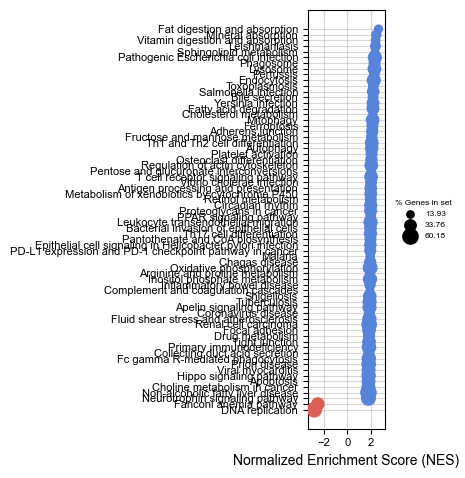

In [54]:
# calculate GSEA on COM
Q_THRESH = 0.01
selected_gene_set = "KEGG_2021_Human" # MSigDB_Hallmark_2020
pre_res = gp.prerank(rnk = group_com_dict['control']['epithelium']['com_01'].sort_values(ascending=True),
                     gene_sets=selected_gene_set,threads=4, min_size=5,max_size=1000,
                     permutation_num=1000, outdir=None, seed=6,verbose=False)

importlib.reload(plot_gsea)
if pre_res.res2d['FDR q-val'].min() < Q_THRESH:
    _ = plot_gsea.plot_GSEA(pre_res.res2d, qval_thresh=Q_THRESH)
else:
    print("No significant gene sets")

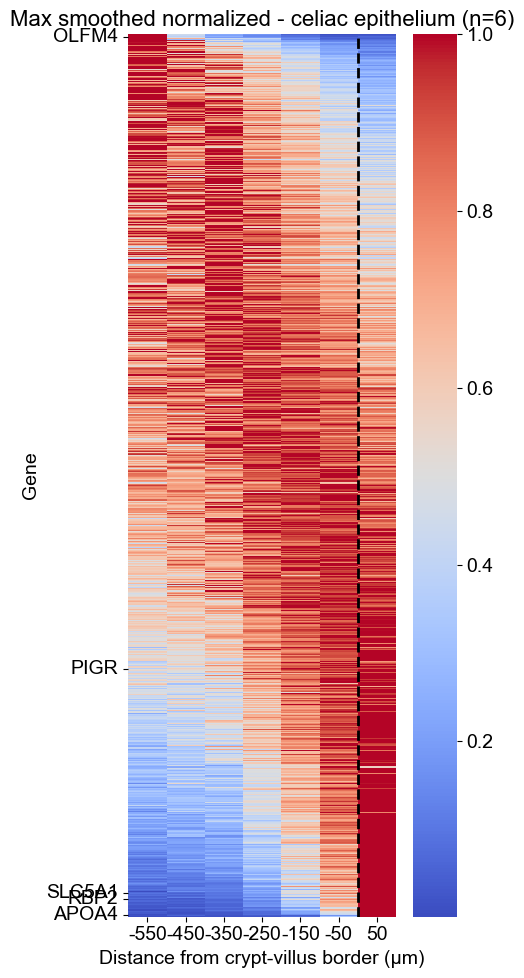

2026-01-20 10:46:06,585 [WARNING] Duplicated values found in preranked stats: 1.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Q-value thresh: 0.01


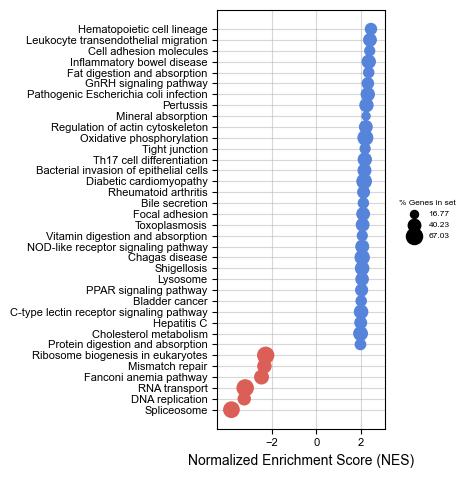

In [55]:
plot_cv_carpet(all_ad, group_com_dict, my_group='celiac', compartment='epithelium', genes2show=["OLFM4","PIGR","SLC5A1","RBP2","APOA4","JCHAIN"], smoothing=True, cmap='coolwarm')
# calculate GSEA on COM
Q_THRESH = 0.01
selected_gene_set = "KEGG_2021_Human" # MSigDB_Hallmark_2020
pre_res = gp.prerank(rnk = group_com_dict['celiac']['epithelium']['com_01'].sort_values(ascending=True),
                     gene_sets=selected_gene_set,threads=4, min_size=5,max_size=1000,
                     permutation_num=1000, outdir=None, seed=6,verbose=False)

importlib.reload(plot_gsea)
if pre_res.res2d['FDR q-val'].min() < Q_THRESH:
    _ = plot_gsea.plot_GSEA(pre_res.res2d, qval_thresh=Q_THRESH)
else:
    print("No significant gene sets")

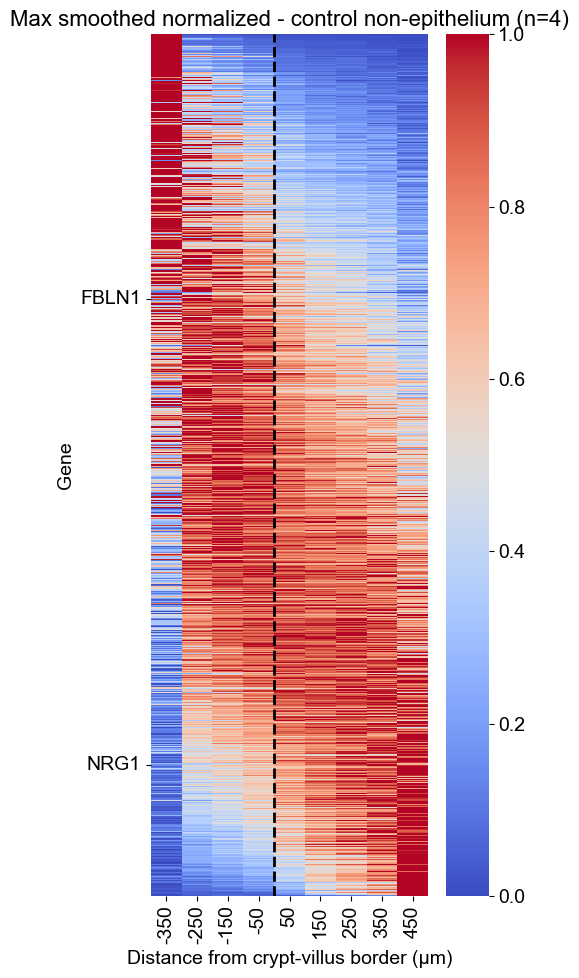

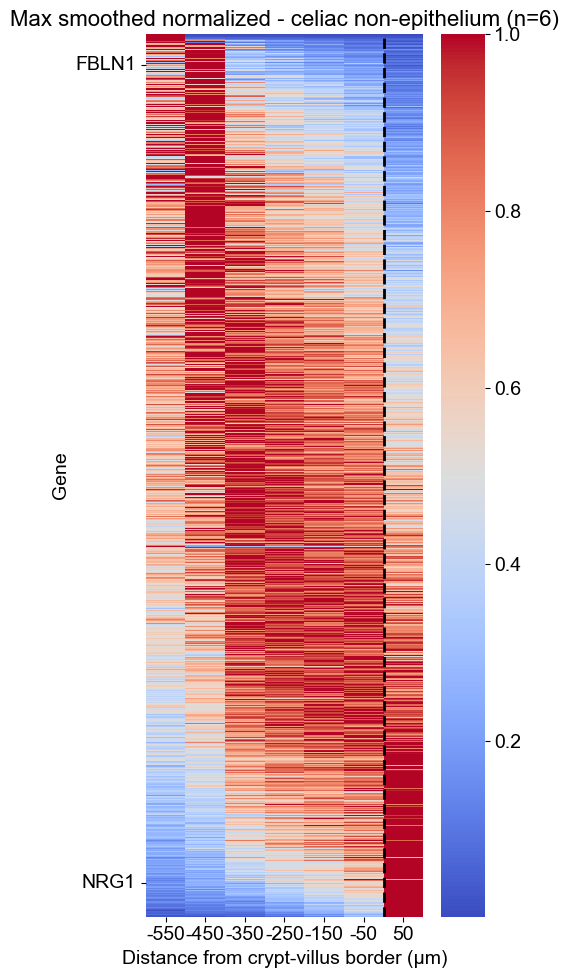

In [58]:
my_compartment='non_epithelium'
my_group='control'

# stromal_genes_to_show = ["WNT4","WNT2B","WNT5A","BMP2","BMP7","RSPO3","NRG1","BMP5"]
stromal_genes_to_show = ["BMP8B","BMP2","WNT9A"]
stromal_genes_to_show = ["NRG1","FBLN1"]
plot_cv_carpet(all_ad, group_com_dict, my_group="control", compartment=my_compartment, genes2show=stromal_genes_to_show, EXP_THRESH=1e-5, smoothing=True, cmap='coolwarm')
plot_cv_carpet(all_ad, group_com_dict, my_group="celiac", compartment=my_compartment, genes2show=stromal_genes_to_show, EXP_THRESH=1e-5, smoothing=True, cmap='coolwarm')

# Q_THRESH = 0.01
# selected_gene_set = "KEGG_2021_Human" # MSigDB_Hallmark_2020
# pre_res = gp.prerank(rnk = group_com_dict[my_group][my_compartment]['com_01'].sort_values(ascending=True),
#                      gene_sets=selected_gene_set,threads=4, min_size=5,max_size=1000,
#                      permutation_num=1000, outdir=None, seed=6,verbose=False)

# importlib.reload(plot_gsea)
# if pre_res.res2d['FDR q-val'].min() < Q_THRESH:
#     _ = plot_gsea.plot_GSEA(pre_res.res2d, qval_thresh=Q_THRESH)
# else:
#     print("No significant gene sets")


In [59]:
print(datetime.now())

2026-01-20 10:46:28.915417


In [60]:
print(session_info2.session_info(dependencies=True))

pandas	2.3.2
scanpy	1.11.4
numpy	2.2.6
tqdm	4.67.1
seaborn	0.13.2
matplotlib	3.10.6
geopandas	1.1.1
scipy	1.15.3
dill	0.4.0
gseapy	1.1.10
plotly	6.3.0
adjustText	1.3.0
statsmodels	0.14.5
scikit-image	0.25.2
tifffile	2025.8.28
shapely	2.1.1
anndata	0.12.2
----	----
decorator	5.2.1
rpds-py	0.27.1
nbformat	5.10.4
pyproj	3.7.2
toolz	1.0.0
natsort	8.4.0
referencing	0.36.2
setuptools	78.1.1
idna	3.10
sphinxcontrib-htmlhelp	2.1.0
jupyter_client	8.6.3
wrapt	1.17.3
sphinxcontrib-jsmath	1.0.1
pytz	2025.2
prompt_toolkit	3.0.52
kiwisolver	1.4.9
igraph	0.11.9
openpyxl	3.1.5
asttokens	3.0.0
python-dateutil	2.9.0.post0
xarray	2025.9.0
tornado	6.5.2
patsy	1.0.1
narwhals	2.5.0
pyzmq	27.1.0
jsonschema-specifications	2025.9.1
pyparsing	3.2.3
debugpy	1.8.16
Jinja2	3.1.6
typing_extensions	4.15.0
session-info2	0.2.1
Cython	3.1.4
jsonschema	4.25.1
lazy_loader	0.4
certifi	2025.8.3 (2025.08.03)
dask	2024.11.2
jedi	0.19.2
numba	0.61.2
matplotlib-inline	0.1.7
stack-data	0.6.3
ipykernel	6.30.1
charset-normalizer	